# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

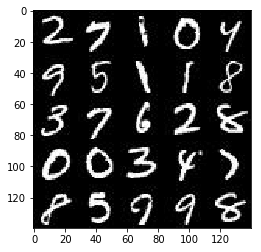

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

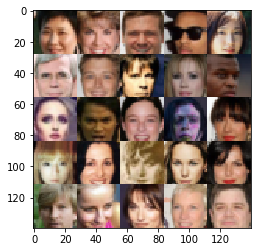

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [53]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_image = tf.placeholder(shape=[None, image_width, image_height, image_channels], 
                                 dtype=tf.float32,
                                 name='input_image')
    
    input_z = tf.placeholder(shape=[None, z_dim], 
                             dtype=tf.float32,
                             name='input_z')
    
    learning_rate = tf.placeholder(
                                   dtype=tf.float32, 
                                   name='learning_rate')
    
    return input_image, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [41]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    
    alpha = 0.1
    
    with tf.variable_scope('discriminator', reuse=reuse):
       
        # Layer 1
        conv_l1 = tf.layers.conv2d(images, 64, 5, 2, padding='SAME')
        conv_l1 = tf.maximum(alpha * conv_l1, conv_l1)
        
        # Layer 2
        conv_l2 = tf.layers.conv2d(conv_l1, 128, 5, 2, padding='SAME')
        conv_l2 = tf.layers.batch_normalization(conv_l2, training=True)
        conv_l2 = tf.maximum(alpha * conv_l2, conv_l2)
        
        # Layer 3
        conv_l3 = tf.layers.conv2d(conv_l2, 256, 5, 2, padding='SAME')
        conv_l3 = tf.layers.batch_normalization(conv_l3, training=True)
        conv_l3 = tf.maximum(alpha * conv_l3, conv_l3)
        
        # Flatten
        flat = tf.reshape(conv_l3, (-1, 4 * 4 * 256))
        
        # Dense layer
        logits = tf.layers.dense(flat, 1)
        logits = tf.layers.dropout(logits, rate=0.5)
        
        # Output
        output = tf.sigmoid(logits)
        
    return output, logits



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [54]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha = 0.1
    
    with tf.variable_scope('generator', reuse=not(is_train)):
        
        # FC 1
        fc1 = tf.layers.dense(inputs=z, units=7 * 7 * 128)
        fc1 = tf.reshape(fc1, (-1, 7, 7, 128))
        fc1 = tf.layers.batch_normalization(fc1, training=is_train)
        fc1 = tf.maximum(alpha * fc1, fc1)
        
        # Layer 2
        conv_l2 = tf.layers.conv2d_transpose(fc1, 64, 5, 2, padding='SAME')
        conv_l2 = tf.layers.batch_normalization(conv_l2, training=is_train)
        conv_l2 = tf.maximum(alpha * conv_l2, conv_l2)
        
        # Layer 3
        conv_l3 = tf.layers.conv2d_transpose(conv_l2, out_channel_dim, 5, 2, padding='SAME')
        
        # Output
        output = tf.tanh(conv_l3)

    return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [55]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """    
    import numpy as np
    
    generative_model = generator(input_z, out_channel_dim)
    
    disc_model_real_images, disc_logits_real_images = discriminator(input_real)
    
    disc_model_prod_images, disc_logits_prod_images = discriminator(generative_model, True)
    
    aux_real = tf.nn.sigmoid_cross_entropy_with_logits(logits=disc_logits_real_images, 
                                                  labels=tf.ones_like(disc_logits_real_images)*np.random.uniform(0.7, 1.2))
    
    aux_prod = tf.nn.sigmoid_cross_entropy_with_logits(logits=disc_logits_prod_images,
                                labels=tf.zeros_like(disc_logits_prod_images)*np.random.uniform(0.0, 0.3))
    
    disc_loss_real_images = tf.reduce_mean(aux_real)
    disc_loss_prod_images = tf.reduce_mean(aux_prod)
    
    discriminative_loss = disc_loss_real_images + disc_loss_prod_images
    
    
    aux_generative = tf.nn.sigmoid_cross_entropy_with_logits(logits=disc_logits_prod_images, labels=tf.ones_like(disc_model_prod_images))    
    generative_loss = tf.reduce_mean(aux_generative)
    
    return discriminative_loss, generative_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [56]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    
    trainable_var = tf.trainable_variables()
#     print(trainable_var[0].name)
    
    generative_var = [v for v in trainable_var if v.name.startswith('generator')]
    discriminative_var = [v for v in trainable_var if v.name.startswith('discriminator')]

    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate, 
                                                        beta1=beta1)
        
        genTraining_operation = optimizer.minimize(g_loss, var_list=generative_var)
        discTraining_operation = optimizer.minimize(d_loss, var_list=discriminative_var)
        
    return discTraining_operation, genTraining_operation


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [57]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [72]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
       # TODO: Build Model
    
    input_image, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    disc_loss, gen_loss = model_loss(input_image, input_z, data_shape[3])
    disc_opt, gen_opt = model_opt(disc_loss, gen_loss, lr, beta1)

    steps = 0
    print_every = 10
    show_every = 100

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model

                steps += 1
                batch_images = batch_images*2
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                sess.run(gen_opt, feed_dict={input_image: batch_images, input_z: batch_z, lr: learning_rate})
                sess.run(disc_opt, feed_dict={input_image: batch_images, input_z: batch_z, lr: learning_rate})
            
                if steps % print_every == 0:
                    train_disc_loss = disc_loss.eval(feed_dict={input_image: batch_images, input_z: batch_z})
                    train_gen_loss = gen_loss.eval(feed_dict={input_z: batch_z})
                    print("Epoch {}/{} ---".format(epoch_i + 1, epoch_count),
                          "Generator Loss: {:.4f} ---".format(train_gen_loss),
                          "Discriminator Loss: {:.4f}".format(train_disc_loss))

                if steps % show_every == 0:
                    show_generator_output(sess, batch_size, input_z, data_shape[3], data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2 --- Generator Loss: 3.7373 --- Discriminator Loss: 0.5156
Epoch 1/2 --- Generator Loss: 5.3116 --- Discriminator Loss: 1.0694
Epoch 1/2 --- Generator Loss: 3.3942 --- Discriminator Loss: 0.5442
Epoch 1/2 --- Generator Loss: 4.0152 --- Discriminator Loss: 0.5240
Epoch 1/2 --- Generator Loss: 4.2061 --- Discriminator Loss: 0.5899
Epoch 1/2 --- Generator Loss: 3.9961 --- Discriminator Loss: 0.5275
Epoch 1/2 --- Generator Loss: 7.7226 --- Discriminator Loss: 1.1160
Epoch 1/2 --- Generator Loss: 3.7472 --- Discriminator Loss: 0.4845
Epoch 1/2 --- Generator Loss: 2.9181 --- Discriminator Loss: 0.5579
Epoch 1/2 --- Generator Loss: 2.7105 --- Discriminator Loss: 0.5360


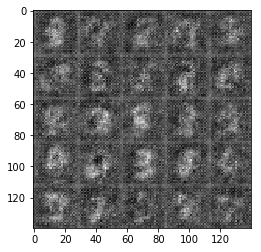

Epoch 1/2 --- Generator Loss: 2.0208 --- Discriminator Loss: 0.6265
Epoch 1/2 --- Generator Loss: 1.7696 --- Discriminator Loss: 0.6941
Epoch 1/2 --- Generator Loss: 0.3772 --- Discriminator Loss: 2.0724
Epoch 1/2 --- Generator Loss: 2.4516 --- Discriminator Loss: 0.5338
Epoch 1/2 --- Generator Loss: 5.8615 --- Discriminator Loss: 1.6113
Epoch 1/2 --- Generator Loss: 3.5981 --- Discriminator Loss: 0.6825
Epoch 1/2 --- Generator Loss: 2.5291 --- Discriminator Loss: 0.5569
Epoch 1/2 --- Generator Loss: 1.5033 --- Discriminator Loss: 0.7351
Epoch 1/2 --- Generator Loss: 0.8550 --- Discriminator Loss: 1.1566
Epoch 1/2 --- Generator Loss: 2.6721 --- Discriminator Loss: 0.5587


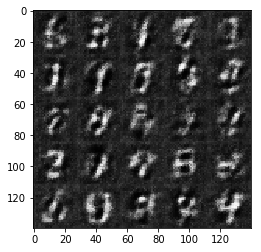

Epoch 1/2 --- Generator Loss: 4.7706 --- Discriminator Loss: 1.1669
Epoch 1/2 --- Generator Loss: 2.0332 --- Discriminator Loss: 0.5890
Epoch 1/2 --- Generator Loss: 1.3865 --- Discriminator Loss: 0.7856
Epoch 1/2 --- Generator Loss: 3.2600 --- Discriminator Loss: 0.5939
Epoch 1/2 --- Generator Loss: 5.4399 --- Discriminator Loss: 1.5082
Epoch 1/2 --- Generator Loss: 2.7019 --- Discriminator Loss: 0.5968
Epoch 1/2 --- Generator Loss: 3.8184 --- Discriminator Loss: 0.6804
Epoch 1/2 --- Generator Loss: 2.1052 --- Discriminator Loss: 0.5692
Epoch 1/2 --- Generator Loss: 1.2787 --- Discriminator Loss: 0.8190
Epoch 1/2 --- Generator Loss: 2.0402 --- Discriminator Loss: 0.5742


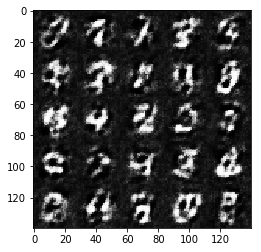

Epoch 1/2 --- Generator Loss: 3.6461 --- Discriminator Loss: 0.6963
Epoch 1/2 --- Generator Loss: 3.3660 --- Discriminator Loss: 0.7493
Epoch 1/2 --- Generator Loss: 3.6435 --- Discriminator Loss: 0.8089
Epoch 1/2 --- Generator Loss: 2.4111 --- Discriminator Loss: 0.5550
Epoch 1/2 --- Generator Loss: 3.1915 --- Discriminator Loss: 0.5158
Epoch 1/2 --- Generator Loss: 3.2385 --- Discriminator Loss: 0.8107
Epoch 1/2 --- Generator Loss: 2.9357 --- Discriminator Loss: 0.5017
Epoch 1/2 --- Generator Loss: 1.1296 --- Discriminator Loss: 0.9285
Epoch 1/2 --- Generator Loss: 2.5610 --- Discriminator Loss: 0.5214
Epoch 1/2 --- Generator Loss: 5.1789 --- Discriminator Loss: 1.0864


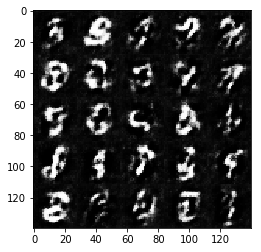

Epoch 1/2 --- Generator Loss: 1.9207 --- Discriminator Loss: 0.5830
Epoch 1/2 --- Generator Loss: 1.3500 --- Discriminator Loss: 0.8281
Epoch 1/2 --- Generator Loss: 2.7415 --- Discriminator Loss: 0.5305
Epoch 1/2 --- Generator Loss: 1.6633 --- Discriminator Loss: 0.6523
Epoch 1/2 --- Generator Loss: 1.1769 --- Discriminator Loss: 0.8410
Epoch 1/2 --- Generator Loss: 1.2548 --- Discriminator Loss: 0.8069
Epoch 1/2 --- Generator Loss: 1.0099 --- Discriminator Loss: 1.1216
Epoch 1/2 --- Generator Loss: 1.7823 --- Discriminator Loss: 0.6344
Epoch 1/2 --- Generator Loss: 2.0258 --- Discriminator Loss: 0.5936
Epoch 1/2 --- Generator Loss: 1.5992 --- Discriminator Loss: 0.6597


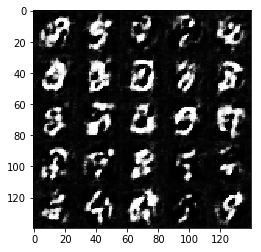

Epoch 1/2 --- Generator Loss: 2.4115 --- Discriminator Loss: 0.5674
Epoch 1/2 --- Generator Loss: 3.9007 --- Discriminator Loss: 0.6111
Epoch 1/2 --- Generator Loss: 1.8859 --- Discriminator Loss: 0.6102
Epoch 1/2 --- Generator Loss: 4.1122 --- Discriminator Loss: 0.7041
Epoch 1/2 --- Generator Loss: 2.9428 --- Discriminator Loss: 0.5352
Epoch 1/2 --- Generator Loss: 4.1821 --- Discriminator Loss: 0.7028
Epoch 1/2 --- Generator Loss: 2.1203 --- Discriminator Loss: 0.5582
Epoch 1/2 --- Generator Loss: 1.6889 --- Discriminator Loss: 0.6748
Epoch 1/2 --- Generator Loss: 1.0468 --- Discriminator Loss: 1.0257
Epoch 1/2 --- Generator Loss: 2.8575 --- Discriminator Loss: 0.5378


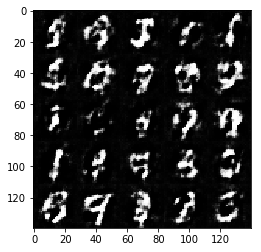

Epoch 1/2 --- Generator Loss: 2.7258 --- Discriminator Loss: 0.5157
Epoch 1/2 --- Generator Loss: 4.9132 --- Discriminator Loss: 1.0459
Epoch 1/2 --- Generator Loss: 2.6377 --- Discriminator Loss: 0.5062
Epoch 1/2 --- Generator Loss: 1.5783 --- Discriminator Loss: 0.6696
Epoch 1/2 --- Generator Loss: 1.4595 --- Discriminator Loss: 0.8188
Epoch 1/2 --- Generator Loss: 1.7160 --- Discriminator Loss: 0.7207
Epoch 1/2 --- Generator Loss: 1.8880 --- Discriminator Loss: 0.6523
Epoch 1/2 --- Generator Loss: 3.5189 --- Discriminator Loss: 0.6520
Epoch 1/2 --- Generator Loss: 2.1156 --- Discriminator Loss: 0.5853
Epoch 1/2 --- Generator Loss: 3.3489 --- Discriminator Loss: 0.5221


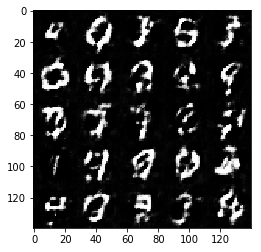

Epoch 1/2 --- Generator Loss: 1.8787 --- Discriminator Loss: 0.6174
Epoch 1/2 --- Generator Loss: 2.4661 --- Discriminator Loss: 0.5161
Epoch 1/2 --- Generator Loss: 3.5207 --- Discriminator Loss: 0.4990
Epoch 1/2 --- Generator Loss: 3.3184 --- Discriminator Loss: 0.5704
Epoch 1/2 --- Generator Loss: 2.0689 --- Discriminator Loss: 0.5708
Epoch 1/2 --- Generator Loss: 2.7713 --- Discriminator Loss: 0.4901
Epoch 1/2 --- Generator Loss: 2.0720 --- Discriminator Loss: 0.5867
Epoch 1/2 --- Generator Loss: 4.0875 --- Discriminator Loss: 0.8383
Epoch 1/2 --- Generator Loss: 2.5805 --- Discriminator Loss: 0.5089
Epoch 1/2 --- Generator Loss: 2.7825 --- Discriminator Loss: 0.5032


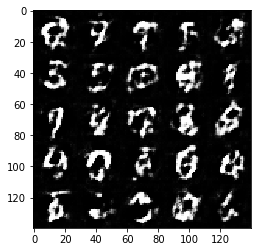

Epoch 1/2 --- Generator Loss: 1.4507 --- Discriminator Loss: 0.8020
Epoch 1/2 --- Generator Loss: 2.3467 --- Discriminator Loss: 0.5340
Epoch 1/2 --- Generator Loss: 3.3069 --- Discriminator Loss: 0.4775
Epoch 1/2 --- Generator Loss: 1.1205 --- Discriminator Loss: 0.9462
Epoch 1/2 --- Generator Loss: 3.0324 --- Discriminator Loss: 0.4682
Epoch 1/2 --- Generator Loss: 2.9918 --- Discriminator Loss: 0.5214
Epoch 1/2 --- Generator Loss: 2.3174 --- Discriminator Loss: 0.5326
Epoch 1/2 --- Generator Loss: 3.7066 --- Discriminator Loss: 0.6498
Epoch 1/2 --- Generator Loss: 3.4789 --- Discriminator Loss: 0.4893
Epoch 1/2 --- Generator Loss: 4.0483 --- Discriminator Loss: 0.5481


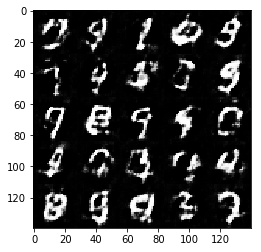

Epoch 1/2 --- Generator Loss: 1.5862 --- Discriminator Loss: 0.7556
Epoch 1/2 --- Generator Loss: 4.4521 --- Discriminator Loss: 0.6536
Epoch 1/2 --- Generator Loss: 3.5044 --- Discriminator Loss: 0.6293
Epoch 1/2 --- Generator Loss: 3.8453 --- Discriminator Loss: 0.5261
Epoch 1/2 --- Generator Loss: 3.0990 --- Discriminator Loss: 0.4819
Epoch 1/2 --- Generator Loss: 1.5451 --- Discriminator Loss: 0.8345
Epoch 1/2 --- Generator Loss: 1.8446 --- Discriminator Loss: 0.6282
Epoch 1/2 --- Generator Loss: 3.8106 --- Discriminator Loss: 0.6394
Epoch 1/2 --- Generator Loss: 2.9479 --- Discriminator Loss: 0.4794
Epoch 1/2 --- Generator Loss: 3.3587 --- Discriminator Loss: 0.5325


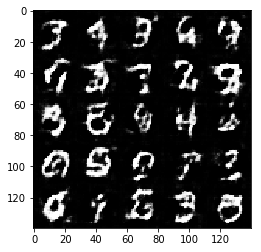

Epoch 1/2 --- Generator Loss: 1.7569 --- Discriminator Loss: 0.6482
Epoch 1/2 --- Generator Loss: 2.7826 --- Discriminator Loss: 0.5430
Epoch 1/2 --- Generator Loss: 3.6513 --- Discriminator Loss: 0.6183
Epoch 1/2 --- Generator Loss: 2.6173 --- Discriminator Loss: 0.5081
Epoch 1/2 --- Generator Loss: 2.7830 --- Discriminator Loss: 0.4995
Epoch 1/2 --- Generator Loss: 3.5085 --- Discriminator Loss: 0.5458
Epoch 1/2 --- Generator Loss: 3.0843 --- Discriminator Loss: 0.4964
Epoch 1/2 --- Generator Loss: 2.3142 --- Discriminator Loss: 0.5431
Epoch 1/2 --- Generator Loss: 2.4664 --- Discriminator Loss: 0.5782
Epoch 1/2 --- Generator Loss: 2.3864 --- Discriminator Loss: 0.5240


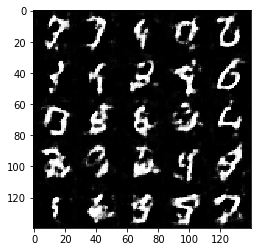

Epoch 1/2 --- Generator Loss: 3.4012 --- Discriminator Loss: 0.5195
Epoch 1/2 --- Generator Loss: 1.7458 --- Discriminator Loss: 0.6469
Epoch 1/2 --- Generator Loss: 2.0520 --- Discriminator Loss: 0.5783
Epoch 1/2 --- Generator Loss: 2.8799 --- Discriminator Loss: 0.4841
Epoch 1/2 --- Generator Loss: 0.9349 --- Discriminator Loss: 1.1131
Epoch 1/2 --- Generator Loss: 3.1510 --- Discriminator Loss: 0.5729
Epoch 1/2 --- Generator Loss: 4.1802 --- Discriminator Loss: 0.7732
Epoch 1/2 --- Generator Loss: 2.0349 --- Discriminator Loss: 0.5982
Epoch 1/2 --- Generator Loss: 3.7198 --- Discriminator Loss: 0.7040
Epoch 1/2 --- Generator Loss: 3.0418 --- Discriminator Loss: 0.5791


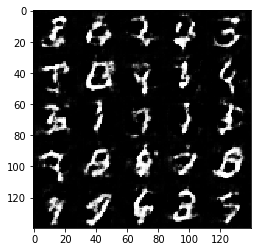

Epoch 1/2 --- Generator Loss: 2.7394 --- Discriminator Loss: 0.5580
Epoch 1/2 --- Generator Loss: 2.7672 --- Discriminator Loss: 0.4865
Epoch 1/2 --- Generator Loss: 1.3904 --- Discriminator Loss: 0.8468
Epoch 1/2 --- Generator Loss: 2.2552 --- Discriminator Loss: 0.5387
Epoch 1/2 --- Generator Loss: 0.9071 --- Discriminator Loss: 1.1108
Epoch 1/2 --- Generator Loss: 2.1510 --- Discriminator Loss: 0.5562
Epoch 1/2 --- Generator Loss: 4.1080 --- Discriminator Loss: 0.7219
Epoch 1/2 --- Generator Loss: 1.6214 --- Discriminator Loss: 0.7544
Epoch 1/2 --- Generator Loss: 2.6332 --- Discriminator Loss: 0.5037
Epoch 1/2 --- Generator Loss: 2.8943 --- Discriminator Loss: 0.5176


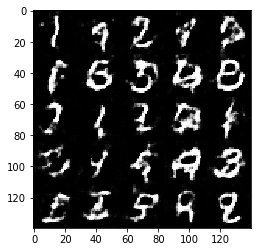

Epoch 1/2 --- Generator Loss: 2.3439 --- Discriminator Loss: 0.5341
Epoch 1/2 --- Generator Loss: 4.3119 --- Discriminator Loss: 0.7834
Epoch 1/2 --- Generator Loss: 1.9432 --- Discriminator Loss: 0.5687
Epoch 1/2 --- Generator Loss: 2.4066 --- Discriminator Loss: 0.5285
Epoch 1/2 --- Generator Loss: 1.0344 --- Discriminator Loss: 1.0681
Epoch 1/2 --- Generator Loss: 2.0516 --- Discriminator Loss: 0.5722
Epoch 1/2 --- Generator Loss: 2.4426 --- Discriminator Loss: 0.5236
Epoch 1/2 --- Generator Loss: 3.7610 --- Discriminator Loss: 0.5488
Epoch 1/2 --- Generator Loss: 2.5594 --- Discriminator Loss: 0.5219
Epoch 1/2 --- Generator Loss: 3.3990 --- Discriminator Loss: 0.4936


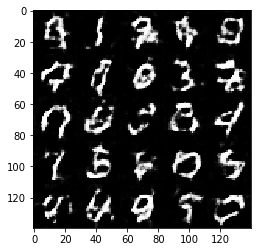

Epoch 1/2 --- Generator Loss: 3.0284 --- Discriminator Loss: 0.7052
Epoch 1/2 --- Generator Loss: 1.8492 --- Discriminator Loss: 0.5884
Epoch 1/2 --- Generator Loss: 2.4172 --- Discriminator Loss: 0.5149
Epoch 1/2 --- Generator Loss: 3.0530 --- Discriminator Loss: 0.4866
Epoch 1/2 --- Generator Loss: 3.0545 --- Discriminator Loss: 0.5715
Epoch 1/2 --- Generator Loss: 1.3933 --- Discriminator Loss: 0.7394
Epoch 1/2 --- Generator Loss: 2.9402 --- Discriminator Loss: 0.5790
Epoch 1/2 --- Generator Loss: 3.4910 --- Discriminator Loss: 0.6894
Epoch 1/2 --- Generator Loss: 2.0475 --- Discriminator Loss: 0.5766
Epoch 1/2 --- Generator Loss: 0.8992 --- Discriminator Loss: 1.1816


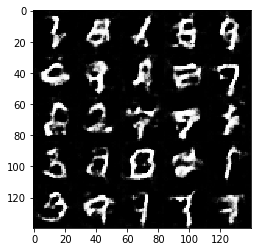

Epoch 1/2 --- Generator Loss: 3.4524 --- Discriminator Loss: 0.5258
Epoch 1/2 --- Generator Loss: 3.0788 --- Discriminator Loss: 0.6472
Epoch 1/2 --- Generator Loss: 2.8449 --- Discriminator Loss: 0.5445
Epoch 1/2 --- Generator Loss: 3.9666 --- Discriminator Loss: 0.8691
Epoch 1/2 --- Generator Loss: 2.8417 --- Discriminator Loss: 0.5291
Epoch 1/2 --- Generator Loss: 0.9684 --- Discriminator Loss: 1.0498
Epoch 1/2 --- Generator Loss: 1.9451 --- Discriminator Loss: 0.6371
Epoch 1/2 --- Generator Loss: 3.4403 --- Discriminator Loss: 0.5869
Epoch 1/2 --- Generator Loss: 2.5057 --- Discriminator Loss: 0.5275
Epoch 1/2 --- Generator Loss: 1.4545 --- Discriminator Loss: 0.7614


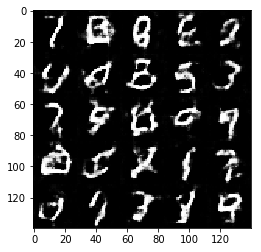

Epoch 1/2 --- Generator Loss: 2.9007 --- Discriminator Loss: 0.5019
Epoch 1/2 --- Generator Loss: 3.3712 --- Discriminator Loss: 0.5932
Epoch 1/2 --- Generator Loss: 3.6046 --- Discriminator Loss: 0.5797
Epoch 1/2 --- Generator Loss: 3.4355 --- Discriminator Loss: 0.6280
Epoch 1/2 --- Generator Loss: 2.2966 --- Discriminator Loss: 0.5346
Epoch 1/2 --- Generator Loss: 3.3574 --- Discriminator Loss: 0.4775
Epoch 1/2 --- Generator Loss: 1.9347 --- Discriminator Loss: 0.5988
Epoch 1/2 --- Generator Loss: 3.8949 --- Discriminator Loss: 0.7263
Epoch 1/2 --- Generator Loss: 4.1067 --- Discriminator Loss: 0.8117
Epoch 1/2 --- Generator Loss: 3.2920 --- Discriminator Loss: 0.4574


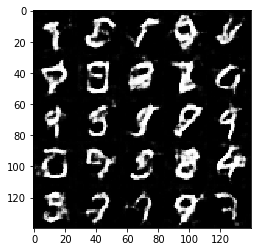

Epoch 1/2 --- Generator Loss: 3.3366 --- Discriminator Loss: 0.5026
Epoch 1/2 --- Generator Loss: 4.9516 --- Discriminator Loss: 1.1365
Epoch 1/2 --- Generator Loss: 4.2150 --- Discriminator Loss: 0.6566
Epoch 1/2 --- Generator Loss: 2.1098 --- Discriminator Loss: 0.5613
Epoch 1/2 --- Generator Loss: 2.1970 --- Discriminator Loss: 0.5615
Epoch 1/2 --- Generator Loss: 2.1173 --- Discriminator Loss: 0.5711
Epoch 1/2 --- Generator Loss: 3.5483 --- Discriminator Loss: 0.6430
Epoch 1/2 --- Generator Loss: 3.4446 --- Discriminator Loss: 0.4841
Epoch 1/2 --- Generator Loss: 2.6703 --- Discriminator Loss: 0.4848
Epoch 1/2 --- Generator Loss: 4.0609 --- Discriminator Loss: 0.6130


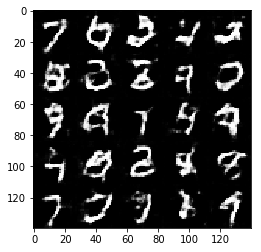

Epoch 1/2 --- Generator Loss: 1.7128 --- Discriminator Loss: 0.7342
Epoch 1/2 --- Generator Loss: 4.4243 --- Discriminator Loss: 1.1752
Epoch 1/2 --- Generator Loss: 0.8068 --- Discriminator Loss: 1.4594
Epoch 1/2 --- Generator Loss: 3.1838 --- Discriminator Loss: 0.4735
Epoch 1/2 --- Generator Loss: 2.9580 --- Discriminator Loss: 0.5107
Epoch 1/2 --- Generator Loss: 3.1329 --- Discriminator Loss: 0.6341
Epoch 1/2 --- Generator Loss: 2.3699 --- Discriminator Loss: 0.5438
Epoch 2/2 --- Generator Loss: 3.6741 --- Discriminator Loss: 0.7012
Epoch 2/2 --- Generator Loss: 3.0837 --- Discriminator Loss: 0.5452
Epoch 2/2 --- Generator Loss: 2.1534 --- Discriminator Loss: 0.5491


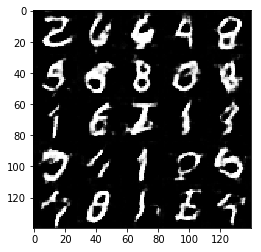

Epoch 2/2 --- Generator Loss: 2.3858 --- Discriminator Loss: 0.5123
Epoch 2/2 --- Generator Loss: 2.1880 --- Discriminator Loss: 0.5646
Epoch 2/2 --- Generator Loss: 2.6192 --- Discriminator Loss: 0.5112
Epoch 2/2 --- Generator Loss: 2.5957 --- Discriminator Loss: 0.4979
Epoch 2/2 --- Generator Loss: 4.4186 --- Discriminator Loss: 0.7645
Epoch 2/2 --- Generator Loss: 3.1705 --- Discriminator Loss: 0.5606
Epoch 2/2 --- Generator Loss: 2.5359 --- Discriminator Loss: 0.4931
Epoch 2/2 --- Generator Loss: 3.0306 --- Discriminator Loss: 0.5880
Epoch 2/2 --- Generator Loss: 1.5467 --- Discriminator Loss: 0.7601
Epoch 2/2 --- Generator Loss: 2.2067 --- Discriminator Loss: 0.5547


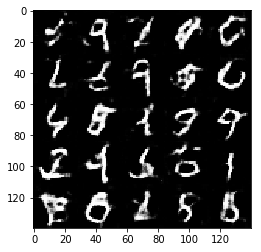

Epoch 2/2 --- Generator Loss: 2.4718 --- Discriminator Loss: 0.5335
Epoch 2/2 --- Generator Loss: 4.2997 --- Discriminator Loss: 0.7689
Epoch 2/2 --- Generator Loss: 2.7170 --- Discriminator Loss: 0.5215
Epoch 2/2 --- Generator Loss: 1.2655 --- Discriminator Loss: 0.8362
Epoch 2/2 --- Generator Loss: 1.0373 --- Discriminator Loss: 1.0721
Epoch 2/2 --- Generator Loss: 2.1209 --- Discriminator Loss: 0.5704
Epoch 2/2 --- Generator Loss: 2.9423 --- Discriminator Loss: 0.4952
Epoch 2/2 --- Generator Loss: 2.6081 --- Discriminator Loss: 0.5013
Epoch 2/2 --- Generator Loss: 2.5736 --- Discriminator Loss: 0.5179
Epoch 2/2 --- Generator Loss: 2.2825 --- Discriminator Loss: 0.5443


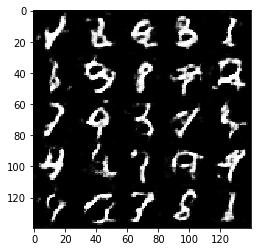

Epoch 2/2 --- Generator Loss: 2.7616 --- Discriminator Loss: 0.4896
Epoch 2/2 --- Generator Loss: 2.6881 --- Discriminator Loss: 0.4960
Epoch 2/2 --- Generator Loss: 1.7129 --- Discriminator Loss: 0.6728
Epoch 2/2 --- Generator Loss: 3.3608 --- Discriminator Loss: 0.5249
Epoch 2/2 --- Generator Loss: 3.5131 --- Discriminator Loss: 0.4838
Epoch 2/2 --- Generator Loss: 1.8227 --- Discriminator Loss: 0.6832
Epoch 2/2 --- Generator Loss: 2.3658 --- Discriminator Loss: 0.5195
Epoch 2/2 --- Generator Loss: 2.5181 --- Discriminator Loss: 0.5175
Epoch 2/2 --- Generator Loss: 1.2769 --- Discriminator Loss: 0.9277
Epoch 2/2 --- Generator Loss: 3.5287 --- Discriminator Loss: 0.5250


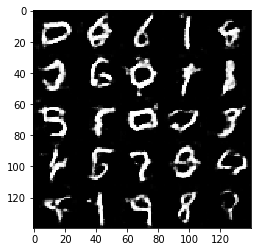

Epoch 2/2 --- Generator Loss: 2.1984 --- Discriminator Loss: 0.5409
Epoch 2/2 --- Generator Loss: 6.2360 --- Discriminator Loss: 2.8245
Epoch 2/2 --- Generator Loss: 2.0371 --- Discriminator Loss: 0.5729
Epoch 2/2 --- Generator Loss: 2.8711 --- Discriminator Loss: 0.5306
Epoch 2/2 --- Generator Loss: 3.1759 --- Discriminator Loss: 0.5146
Epoch 2/2 --- Generator Loss: 2.6654 --- Discriminator Loss: 0.5011
Epoch 2/2 --- Generator Loss: 3.6448 --- Discriminator Loss: 0.4951
Epoch 2/2 --- Generator Loss: 2.7869 --- Discriminator Loss: 0.4941
Epoch 2/2 --- Generator Loss: 3.0165 --- Discriminator Loss: 0.4838
Epoch 2/2 --- Generator Loss: 1.4611 --- Discriminator Loss: 0.8022


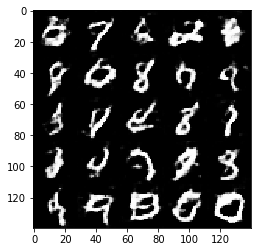

Epoch 2/2 --- Generator Loss: 1.8465 --- Discriminator Loss: 0.6121
Epoch 2/2 --- Generator Loss: 1.8250 --- Discriminator Loss: 0.6911
Epoch 2/2 --- Generator Loss: 3.3790 --- Discriminator Loss: 0.5821
Epoch 2/2 --- Generator Loss: 3.5112 --- Discriminator Loss: 0.5940
Epoch 2/2 --- Generator Loss: 3.2808 --- Discriminator Loss: 0.5494
Epoch 2/2 --- Generator Loss: 2.2019 --- Discriminator Loss: 0.5628
Epoch 2/2 --- Generator Loss: 3.4252 --- Discriminator Loss: 0.5630
Epoch 2/2 --- Generator Loss: 3.0472 --- Discriminator Loss: 0.5536
Epoch 2/2 --- Generator Loss: 2.6413 --- Discriminator Loss: 0.4951
Epoch 2/2 --- Generator Loss: 2.4502 --- Discriminator Loss: 0.5266


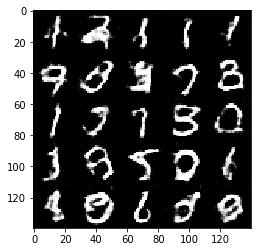

Epoch 2/2 --- Generator Loss: 3.0107 --- Discriminator Loss: 0.4675
Epoch 2/2 --- Generator Loss: 1.7792 --- Discriminator Loss: 0.6772
Epoch 2/2 --- Generator Loss: 3.1824 --- Discriminator Loss: 0.4982
Epoch 2/2 --- Generator Loss: 2.3292 --- Discriminator Loss: 0.5440
Epoch 2/2 --- Generator Loss: 7.2078 --- Discriminator Loss: 3.1818
Epoch 2/2 --- Generator Loss: 3.1828 --- Discriminator Loss: 0.4982
Epoch 2/2 --- Generator Loss: 2.7592 --- Discriminator Loss: 0.4995
Epoch 2/2 --- Generator Loss: 1.8391 --- Discriminator Loss: 0.6086
Epoch 2/2 --- Generator Loss: 1.9406 --- Discriminator Loss: 0.5779
Epoch 2/2 --- Generator Loss: 3.3469 --- Discriminator Loss: 0.4831


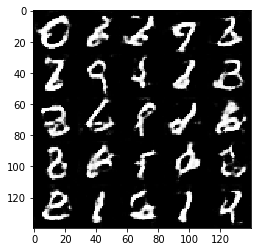

Epoch 2/2 --- Generator Loss: 3.2225 --- Discriminator Loss: 0.4551
Epoch 2/2 --- Generator Loss: 2.6748 --- Discriminator Loss: 0.4810
Epoch 2/2 --- Generator Loss: 3.5234 --- Discriminator Loss: 0.5237
Epoch 2/2 --- Generator Loss: 3.1641 --- Discriminator Loss: 0.4919
Epoch 2/2 --- Generator Loss: 3.7241 --- Discriminator Loss: 0.6519
Epoch 2/2 --- Generator Loss: 5.4375 --- Discriminator Loss: 1.2332
Epoch 2/2 --- Generator Loss: 2.6690 --- Discriminator Loss: 0.4814
Epoch 2/2 --- Generator Loss: 3.0493 --- Discriminator Loss: 0.4635
Epoch 2/2 --- Generator Loss: 3.5424 --- Discriminator Loss: 0.4621
Epoch 2/2 --- Generator Loss: 2.4911 --- Discriminator Loss: 0.5074


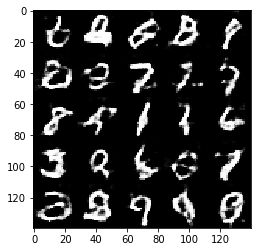

Epoch 2/2 --- Generator Loss: 1.9261 --- Discriminator Loss: 0.6750
Epoch 2/2 --- Generator Loss: 3.6022 --- Discriminator Loss: 0.4775
Epoch 2/2 --- Generator Loss: 2.8908 --- Discriminator Loss: 0.4939
Epoch 2/2 --- Generator Loss: 3.1977 --- Discriminator Loss: 0.4575
Epoch 2/2 --- Generator Loss: 3.6072 --- Discriminator Loss: 0.4637
Epoch 2/2 --- Generator Loss: 1.7121 --- Discriminator Loss: 0.6592
Epoch 2/2 --- Generator Loss: 3.5275 --- Discriminator Loss: 0.4827
Epoch 2/2 --- Generator Loss: 3.2933 --- Discriminator Loss: 0.4510
Epoch 2/2 --- Generator Loss: 3.8033 --- Discriminator Loss: 0.5899
Epoch 2/2 --- Generator Loss: 3.8274 --- Discriminator Loss: 0.5746


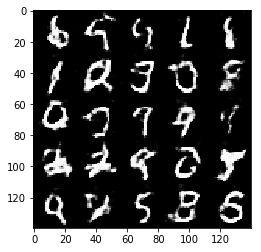

Epoch 2/2 --- Generator Loss: 3.0346 --- Discriminator Loss: 0.5012
Epoch 2/2 --- Generator Loss: 9.5379 --- Discriminator Loss: 4.8844
Epoch 2/2 --- Generator Loss: 2.0891 --- Discriminator Loss: 0.5917
Epoch 2/2 --- Generator Loss: 3.8170 --- Discriminator Loss: 0.5352
Epoch 2/2 --- Generator Loss: 3.2217 --- Discriminator Loss: 0.4792
Epoch 2/2 --- Generator Loss: 3.0101 --- Discriminator Loss: 0.4779
Epoch 2/2 --- Generator Loss: 2.8528 --- Discriminator Loss: 0.4896
Epoch 2/2 --- Generator Loss: 2.8875 --- Discriminator Loss: 0.4699
Epoch 2/2 --- Generator Loss: 1.8328 --- Discriminator Loss: 0.6458
Epoch 2/2 --- Generator Loss: 3.1680 --- Discriminator Loss: 0.4684


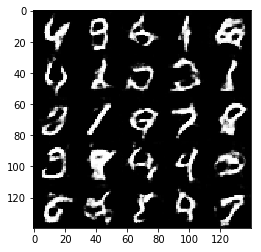

Epoch 2/2 --- Generator Loss: 2.7406 --- Discriminator Loss: 0.4742
Epoch 2/2 --- Generator Loss: 4.2934 --- Discriminator Loss: 0.5980
Epoch 2/2 --- Generator Loss: 1.8801 --- Discriminator Loss: 0.5944
Epoch 2/2 --- Generator Loss: 2.4494 --- Discriminator Loss: 0.5184
Epoch 2/2 --- Generator Loss: 3.1981 --- Discriminator Loss: 0.4987
Epoch 2/2 --- Generator Loss: 3.7751 --- Discriminator Loss: 0.4867
Epoch 2/2 --- Generator Loss: 2.0456 --- Discriminator Loss: 0.6834
Epoch 2/2 --- Generator Loss: 2.7350 --- Discriminator Loss: 0.4969
Epoch 2/2 --- Generator Loss: 1.8612 --- Discriminator Loss: 0.6148
Epoch 2/2 --- Generator Loss: 3.8730 --- Discriminator Loss: 0.4649


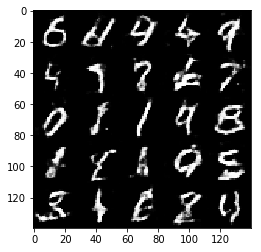

Epoch 2/2 --- Generator Loss: 1.6714 --- Discriminator Loss: 0.7670
Epoch 2/2 --- Generator Loss: 2.4117 --- Discriminator Loss: 0.5229
Epoch 2/2 --- Generator Loss: 1.9608 --- Discriminator Loss: 0.5932
Epoch 2/2 --- Generator Loss: 2.6292 --- Discriminator Loss: 0.4906
Epoch 2/2 --- Generator Loss: 3.1319 --- Discriminator Loss: 0.4602
Epoch 2/2 --- Generator Loss: 2.6756 --- Discriminator Loss: 0.4885
Epoch 2/2 --- Generator Loss: 2.4275 --- Discriminator Loss: 0.5179
Epoch 2/2 --- Generator Loss: 2.5643 --- Discriminator Loss: 0.5087
Epoch 2/2 --- Generator Loss: 2.7883 --- Discriminator Loss: 0.4781
Epoch 2/2 --- Generator Loss: 2.4124 --- Discriminator Loss: 0.5356


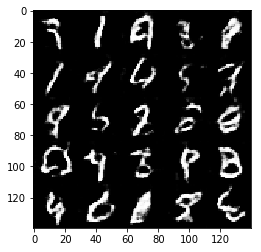

Epoch 2/2 --- Generator Loss: 2.1352 --- Discriminator Loss: 0.5615
Epoch 2/2 --- Generator Loss: 3.2397 --- Discriminator Loss: 0.4457
Epoch 2/2 --- Generator Loss: 3.3578 --- Discriminator Loss: 0.4462
Epoch 2/2 --- Generator Loss: 3.2936 --- Discriminator Loss: 0.4471
Epoch 2/2 --- Generator Loss: 3.3455 --- Discriminator Loss: 0.4845
Epoch 2/2 --- Generator Loss: 2.9804 --- Discriminator Loss: 0.4641
Epoch 2/2 --- Generator Loss: 3.5865 --- Discriminator Loss: 0.4639
Epoch 2/2 --- Generator Loss: 2.3419 --- Discriminator Loss: 0.5348
Epoch 2/2 --- Generator Loss: 2.8393 --- Discriminator Loss: 0.4723
Epoch 2/2 --- Generator Loss: 2.1523 --- Discriminator Loss: 0.5911


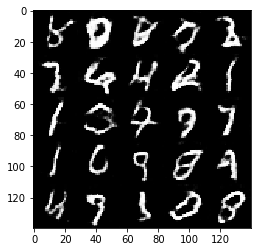

Epoch 2/2 --- Generator Loss: 4.1234 --- Discriminator Loss: 0.5181
Epoch 2/2 --- Generator Loss: 2.7756 --- Discriminator Loss: 0.4938
Epoch 2/2 --- Generator Loss: 3.3652 --- Discriminator Loss: 0.5056
Epoch 2/2 --- Generator Loss: 4.4806 --- Discriminator Loss: 0.6622
Epoch 2/2 --- Generator Loss: 3.2111 --- Discriminator Loss: 0.4549
Epoch 2/2 --- Generator Loss: 1.9434 --- Discriminator Loss: 0.6341
Epoch 2/2 --- Generator Loss: 3.5868 --- Discriminator Loss: 0.4662
Epoch 2/2 --- Generator Loss: 3.5959 --- Discriminator Loss: 0.4846
Epoch 2/2 --- Generator Loss: 3.5018 --- Discriminator Loss: 0.4371
Epoch 2/2 --- Generator Loss: 4.2838 --- Discriminator Loss: 0.4958


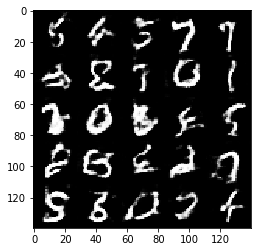

Epoch 2/2 --- Generator Loss: 6.6494 --- Discriminator Loss: 2.3693
Epoch 2/2 --- Generator Loss: 1.8556 --- Discriminator Loss: 0.6536
Epoch 2/2 --- Generator Loss: 3.6127 --- Discriminator Loss: 0.6676
Epoch 2/2 --- Generator Loss: 2.2888 --- Discriminator Loss: 0.5282
Epoch 2/2 --- Generator Loss: 2.9405 --- Discriminator Loss: 0.4651
Epoch 2/2 --- Generator Loss: 2.2471 --- Discriminator Loss: 0.5436
Epoch 2/2 --- Generator Loss: 2.9117 --- Discriminator Loss: 0.4732
Epoch 2/2 --- Generator Loss: 2.2806 --- Discriminator Loss: 0.5836
Epoch 2/2 --- Generator Loss: 4.7563 --- Discriminator Loss: 0.7307
Epoch 2/2 --- Generator Loss: 1.9290 --- Discriminator Loss: 0.5932


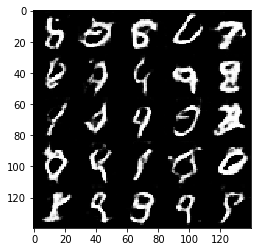

Epoch 2/2 --- Generator Loss: 2.9413 --- Discriminator Loss: 0.4681
Epoch 2/2 --- Generator Loss: 3.0925 --- Discriminator Loss: 0.4548
Epoch 2/2 --- Generator Loss: 2.3782 --- Discriminator Loss: 0.5145
Epoch 2/2 --- Generator Loss: 1.8762 --- Discriminator Loss: 0.6631
Epoch 2/2 --- Generator Loss: 3.6963 --- Discriminator Loss: 0.4385
Epoch 2/2 --- Generator Loss: 3.7418 --- Discriminator Loss: 0.4322
Epoch 2/2 --- Generator Loss: 3.2208 --- Discriminator Loss: 0.4546
Epoch 2/2 --- Generator Loss: 2.6098 --- Discriminator Loss: 0.4961
Epoch 2/2 --- Generator Loss: 3.7944 --- Discriminator Loss: 0.4566
Epoch 2/2 --- Generator Loss: 2.6382 --- Discriminator Loss: 0.4997


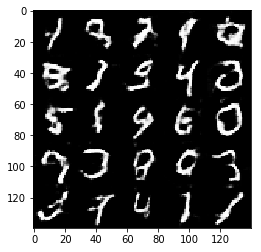

Epoch 2/2 --- Generator Loss: 1.4008 --- Discriminator Loss: 0.8927
Epoch 2/2 --- Generator Loss: 4.0027 --- Discriminator Loss: 0.8830
Epoch 2/2 --- Generator Loss: 3.6093 --- Discriminator Loss: 0.4327
Epoch 2/2 --- Generator Loss: 3.4687 --- Discriminator Loss: 0.5458
Epoch 2/2 --- Generator Loss: 4.3397 --- Discriminator Loss: 0.5677
Epoch 2/2 --- Generator Loss: 2.6211 --- Discriminator Loss: 0.4967
Epoch 2/2 --- Generator Loss: 3.1132 --- Discriminator Loss: 0.4581
Epoch 2/2 --- Generator Loss: 2.9936 --- Discriminator Loss: 0.4622
Epoch 2/2 --- Generator Loss: 3.5658 --- Discriminator Loss: 0.4508
Epoch 2/2 --- Generator Loss: 2.8257 --- Discriminator Loss: 0.4894


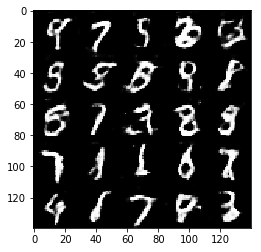

Epoch 2/2 --- Generator Loss: 3.1060 --- Discriminator Loss: 0.4835
Epoch 2/2 --- Generator Loss: 1.7484 --- Discriminator Loss: 0.7395
Epoch 2/2 --- Generator Loss: 4.3603 --- Discriminator Loss: 0.4537
Epoch 2/2 --- Generator Loss: 4.9447 --- Discriminator Loss: 0.9258
Epoch 2/2 --- Generator Loss: 3.4382 --- Discriminator Loss: 0.4539
Epoch 2/2 --- Generator Loss: 3.1496 --- Discriminator Loss: 0.4690
Epoch 2/2 --- Generator Loss: 2.1727 --- Discriminator Loss: 0.5493
Epoch 2/2 --- Generator Loss: 3.0476 --- Discriminator Loss: 0.4698
Epoch 2/2 --- Generator Loss: 3.4079 --- Discriminator Loss: 0.4443
Epoch 2/2 --- Generator Loss: 3.3868 --- Discriminator Loss: 0.4496


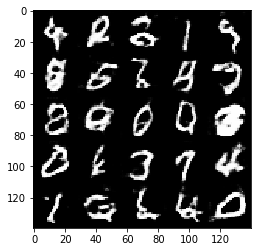

Epoch 2/2 --- Generator Loss: 3.7435 --- Discriminator Loss: 0.5423
Epoch 2/2 --- Generator Loss: 2.9352 --- Discriminator Loss: 0.4794
Epoch 2/2 --- Generator Loss: 3.5099 --- Discriminator Loss: 0.4429
Epoch 2/2 --- Generator Loss: 2.3940 --- Discriminator Loss: 0.5372
Epoch 2/2 --- Generator Loss: 4.3239 --- Discriminator Loss: 0.5421
Epoch 2/2 --- Generator Loss: 3.0337 --- Discriminator Loss: 0.4646
Epoch 2/2 --- Generator Loss: 2.6752 --- Discriminator Loss: 0.4908
Epoch 2/2 --- Generator Loss: 3.3637 --- Discriminator Loss: 0.4445
Epoch 2/2 --- Generator Loss: 3.3915 --- Discriminator Loss: 0.4421
Epoch 2/2 --- Generator Loss: 4.0720 --- Discriminator Loss: 0.4937


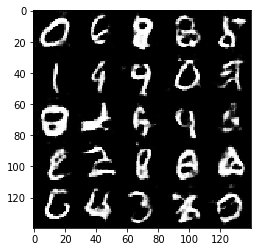

Epoch 2/2 --- Generator Loss: 2.4023 --- Discriminator Loss: 0.5611
Epoch 2/2 --- Generator Loss: 4.2957 --- Discriminator Loss: 0.5163
Epoch 2/2 --- Generator Loss: 3.4913 --- Discriminator Loss: 0.4433
Epoch 2/2 --- Generator Loss: 4.5473 --- Discriminator Loss: 0.6405
Epoch 2/2 --- Generator Loss: 1.7289 --- Discriminator Loss: 0.7844


In [74]:
batch_size = 32
z_dim = 100
learning_rate = 1e-4
beta1 = 0.1


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1 --- Generator Loss: 2.7680 --- Discriminator Loss: -0.9134
Epoch 1/1 --- Generator Loss: 2.4319 --- Discriminator Loss: -1.6219
Epoch 1/1 --- Generator Loss: 2.7497 --- Discriminator Loss: -2.3272
Epoch 1/1 --- Generator Loss: 2.6553 --- Discriminator Loss: -2.9073
Epoch 1/1 --- Generator Loss: 5.6667 --- Discriminator Loss: -2.8718
Epoch 1/1 --- Generator Loss: 18.7317 --- Discriminator Loss: -0.2483
Epoch 1/1 --- Generator Loss: 6.2497 --- Discriminator Loss: -3.5858
Epoch 1/1 --- Generator Loss: 28.6382 --- Discriminator Loss: 17.7800
Epoch 1/1 --- Generator Loss: 5.4314 --- Discriminator Loss: -2.1801
Epoch 1/1 --- Generator Loss: 21.7933 --- Discriminator Loss: 5.1358


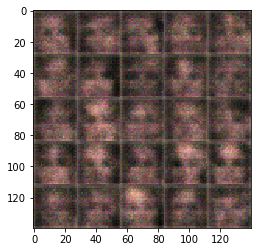

Epoch 1/1 --- Generator Loss: 5.0086 --- Discriminator Loss: -1.7360
Epoch 1/1 --- Generator Loss: 0.8049 --- Discriminator Loss: -0.0814
Epoch 1/1 --- Generator Loss: 4.1501 --- Discriminator Loss: -1.0918
Epoch 1/1 --- Generator Loss: 5.0722 --- Discriminator Loss: -1.2861
Epoch 1/1 --- Generator Loss: 4.3559 --- Discriminator Loss: -1.2532
Epoch 1/1 --- Generator Loss: 3.7163 --- Discriminator Loss: -1.1099
Epoch 1/1 --- Generator Loss: 4.8476 --- Discriminator Loss: -1.6052
Epoch 1/1 --- Generator Loss: 3.0685 --- Discriminator Loss: -1.3642
Epoch 1/1 --- Generator Loss: 2.6704 --- Discriminator Loss: -0.7605
Epoch 1/1 --- Generator Loss: 2.6712 --- Discriminator Loss: -0.8517


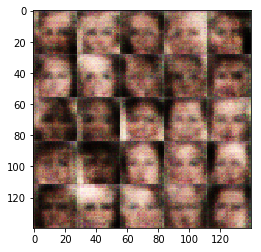

Epoch 1/1 --- Generator Loss: 5.4153 --- Discriminator Loss: -0.6896
Epoch 1/1 --- Generator Loss: 3.6108 --- Discriminator Loss: -1.0353
Epoch 1/1 --- Generator Loss: 10.6779 --- Discriminator Loss: 1.1887
Epoch 1/1 --- Generator Loss: 7.2344 --- Discriminator Loss: -0.2501
Epoch 1/1 --- Generator Loss: 4.5603 --- Discriminator Loss: -0.7429
Epoch 1/1 --- Generator Loss: 3.5013 --- Discriminator Loss: -0.7577
Epoch 1/1 --- Generator Loss: 10.7532 --- Discriminator Loss: 0.9771
Epoch 1/1 --- Generator Loss: 3.2337 --- Discriminator Loss: -0.7660
Epoch 1/1 --- Generator Loss: 2.6980 --- Discriminator Loss: -0.7108
Epoch 1/1 --- Generator Loss: 4.0739 --- Discriminator Loss: -0.3988


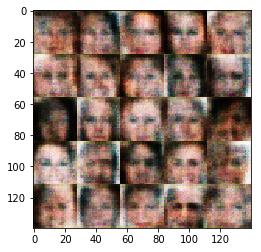

Epoch 1/1 --- Generator Loss: 2.0481 --- Discriminator Loss: -0.5043
Epoch 1/1 --- Generator Loss: 2.6629 --- Discriminator Loss: -0.5773
Epoch 1/1 --- Generator Loss: 2.8246 --- Discriminator Loss: -0.4853
Epoch 1/1 --- Generator Loss: 4.4465 --- Discriminator Loss: -0.3846
Epoch 1/1 --- Generator Loss: 4.4727 --- Discriminator Loss: -0.4839
Epoch 1/1 --- Generator Loss: 2.5272 --- Discriminator Loss: -0.5941
Epoch 1/1 --- Generator Loss: 1.3559 --- Discriminator Loss: -0.3099
Epoch 1/1 --- Generator Loss: 1.6172 --- Discriminator Loss: -0.1969
Epoch 1/1 --- Generator Loss: 2.6469 --- Discriminator Loss: -0.6276
Epoch 1/1 --- Generator Loss: 2.1158 --- Discriminator Loss: -0.5924


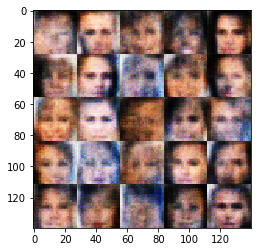

Epoch 1/1 --- Generator Loss: 0.9643 --- Discriminator Loss: 0.3404
Epoch 1/1 --- Generator Loss: 3.1651 --- Discriminator Loss: -0.4318
Epoch 1/1 --- Generator Loss: 2.4754 --- Discriminator Loss: -0.4924
Epoch 1/1 --- Generator Loss: 2.2209 --- Discriminator Loss: -0.5884
Epoch 1/1 --- Generator Loss: 3.6185 --- Discriminator Loss: -0.7460
Epoch 1/1 --- Generator Loss: 3.3755 --- Discriminator Loss: -0.8008
Epoch 1/1 --- Generator Loss: 2.7252 --- Discriminator Loss: -0.4102
Epoch 1/1 --- Generator Loss: 6.0407 --- Discriminator Loss: -0.1422
Epoch 1/1 --- Generator Loss: 2.5657 --- Discriminator Loss: -0.3068
Epoch 1/1 --- Generator Loss: 1.4280 --- Discriminator Loss: -0.1886


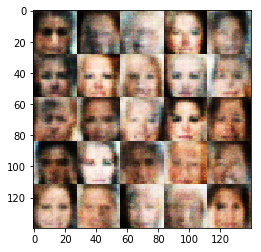

Epoch 1/1 --- Generator Loss: 2.3338 --- Discriminator Loss: -0.5182
Epoch 1/1 --- Generator Loss: 2.4872 --- Discriminator Loss: -0.6191
Epoch 1/1 --- Generator Loss: 2.5905 --- Discriminator Loss: -0.6066
Epoch 1/1 --- Generator Loss: 2.1899 --- Discriminator Loss: -0.3853
Epoch 1/1 --- Generator Loss: 5.6490 --- Discriminator Loss: 0.6922
Epoch 1/1 --- Generator Loss: 2.5543 --- Discriminator Loss: -0.5854
Epoch 1/1 --- Generator Loss: 7.2781 --- Discriminator Loss: 0.7347
Epoch 1/1 --- Generator Loss: 3.6427 --- Discriminator Loss: -0.1947
Epoch 1/1 --- Generator Loss: 5.5209 --- Discriminator Loss: 0.6759
Epoch 1/1 --- Generator Loss: 1.8411 --- Discriminator Loss: -0.3746


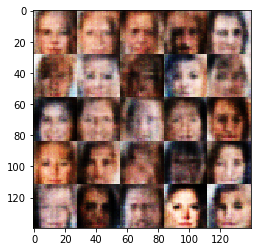

Epoch 1/1 --- Generator Loss: 2.6554 --- Discriminator Loss: -0.3897
Epoch 1/1 --- Generator Loss: 5.8627 --- Discriminator Loss: 1.2502
Epoch 1/1 --- Generator Loss: 2.0685 --- Discriminator Loss: -0.4213
Epoch 1/1 --- Generator Loss: 1.7943 --- Discriminator Loss: -0.2049
Epoch 1/1 --- Generator Loss: 1.9970 --- Discriminator Loss: -0.4652
Epoch 1/1 --- Generator Loss: 7.0904 --- Discriminator Loss: 0.4321
Epoch 1/1 --- Generator Loss: 4.1103 --- Discriminator Loss: -0.3588
Epoch 1/1 --- Generator Loss: 2.7300 --- Discriminator Loss: -0.5918
Epoch 1/1 --- Generator Loss: 3.9685 --- Discriminator Loss: -0.4300
Epoch 1/1 --- Generator Loss: 3.2652 --- Discriminator Loss: -0.2632


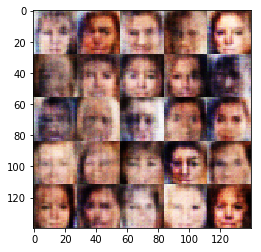

Epoch 1/1 --- Generator Loss: 8.5470 --- Discriminator Loss: 0.1430
Epoch 1/1 --- Generator Loss: 2.3115 --- Discriminator Loss: -0.4704
Epoch 1/1 --- Generator Loss: 7.0943 --- Discriminator Loss: 0.1243
Epoch 1/1 --- Generator Loss: 7.4670 --- Discriminator Loss: 0.8406
Epoch 1/1 --- Generator Loss: 2.4431 --- Discriminator Loss: -0.2947
Epoch 1/1 --- Generator Loss: 1.5499 --- Discriminator Loss: -0.4347
Epoch 1/1 --- Generator Loss: 0.2334 --- Discriminator Loss: 1.3057
Epoch 1/1 --- Generator Loss: 7.8504 --- Discriminator Loss: 0.8281
Epoch 1/1 --- Generator Loss: 2.7899 --- Discriminator Loss: -0.3947
Epoch 1/1 --- Generator Loss: 5.1516 --- Discriminator Loss: -0.0683


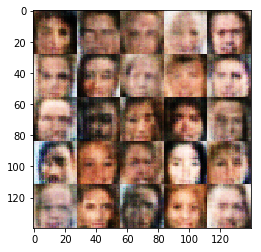

Epoch 1/1 --- Generator Loss: 1.3869 --- Discriminator Loss: -0.1579
Epoch 1/1 --- Generator Loss: 4.0184 --- Discriminator Loss: -0.1727
Epoch 1/1 --- Generator Loss: 3.4014 --- Discriminator Loss: -0.5251
Epoch 1/1 --- Generator Loss: 2.3368 --- Discriminator Loss: -0.1649
Epoch 1/1 --- Generator Loss: 5.4440 --- Discriminator Loss: 0.7440
Epoch 1/1 --- Generator Loss: 6.3558 --- Discriminator Loss: 0.0988
Epoch 1/1 --- Generator Loss: 2.5156 --- Discriminator Loss: -0.2435
Epoch 1/1 --- Generator Loss: 4.9848 --- Discriminator Loss: -0.0097
Epoch 1/1 --- Generator Loss: 2.4405 --- Discriminator Loss: -0.2710
Epoch 1/1 --- Generator Loss: 4.8507 --- Discriminator Loss: -0.0073


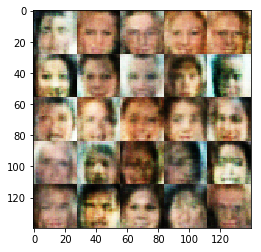

Epoch 1/1 --- Generator Loss: 1.3039 --- Discriminator Loss: -0.2170
Epoch 1/1 --- Generator Loss: 4.0167 --- Discriminator Loss: 0.0368
Epoch 1/1 --- Generator Loss: 5.7788 --- Discriminator Loss: -0.0116
Epoch 1/1 --- Generator Loss: 5.4452 --- Discriminator Loss: 0.0130
Epoch 1/1 --- Generator Loss: 3.6958 --- Discriminator Loss: -0.4335
Epoch 1/1 --- Generator Loss: 6.7070 --- Discriminator Loss: 0.0099
Epoch 1/1 --- Generator Loss: 0.3915 --- Discriminator Loss: 0.7983
Epoch 1/1 --- Generator Loss: 1.5106 --- Discriminator Loss: -0.3185
Epoch 1/1 --- Generator Loss: 1.1286 --- Discriminator Loss: -0.0524
Epoch 1/1 --- Generator Loss: 5.2617 --- Discriminator Loss: 0.6832


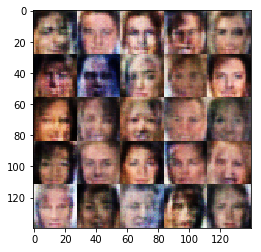

Epoch 1/1 --- Generator Loss: 2.9410 --- Discriminator Loss: -0.2029
Epoch 1/1 --- Generator Loss: 0.5598 --- Discriminator Loss: 0.6508
Epoch 1/1 --- Generator Loss: 1.5886 --- Discriminator Loss: -0.3008
Epoch 1/1 --- Generator Loss: 2.5098 --- Discriminator Loss: 0.0908
Epoch 1/1 --- Generator Loss: 0.2308 --- Discriminator Loss: 1.1217
Epoch 1/1 --- Generator Loss: 1.5087 --- Discriminator Loss: -0.2156
Epoch 1/1 --- Generator Loss: 3.7053 --- Discriminator Loss: 0.2423
Epoch 1/1 --- Generator Loss: 1.1371 --- Discriminator Loss: -0.0945
Epoch 1/1 --- Generator Loss: 3.1539 --- Discriminator Loss: -0.3015
Epoch 1/1 --- Generator Loss: 3.5921 --- Discriminator Loss: -0.1481


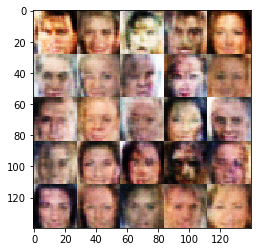

Epoch 1/1 --- Generator Loss: 3.0011 --- Discriminator Loss: -0.2954
Epoch 1/1 --- Generator Loss: 0.4012 --- Discriminator Loss: 0.7148
Epoch 1/1 --- Generator Loss: 0.3571 --- Discriminator Loss: 0.7681
Epoch 1/1 --- Generator Loss: 5.4405 --- Discriminator Loss: 0.7503
Epoch 1/1 --- Generator Loss: 1.6665 --- Discriminator Loss: -0.2440
Epoch 1/1 --- Generator Loss: 1.4957 --- Discriminator Loss: -0.0448
Epoch 1/1 --- Generator Loss: 2.0173 --- Discriminator Loss: -0.1839
Epoch 1/1 --- Generator Loss: 2.6246 --- Discriminator Loss: -0.1128
Epoch 1/1 --- Generator Loss: 0.7698 --- Discriminator Loss: 0.1449
Epoch 1/1 --- Generator Loss: 3.2775 --- Discriminator Loss: 0.2494


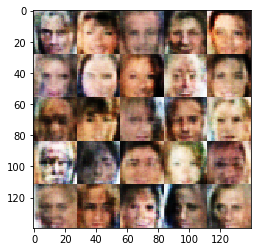

Epoch 1/1 --- Generator Loss: 4.3187 --- Discriminator Loss: 0.5664
Epoch 1/1 --- Generator Loss: 3.0349 --- Discriminator Loss: -0.2703
Epoch 1/1 --- Generator Loss: 1.5160 --- Discriminator Loss: -0.1547
Epoch 1/1 --- Generator Loss: 0.7994 --- Discriminator Loss: 0.2662
Epoch 1/1 --- Generator Loss: 1.6850 --- Discriminator Loss: -0.0726
Epoch 1/1 --- Generator Loss: 4.4318 --- Discriminator Loss: 0.2789
Epoch 1/1 --- Generator Loss: 2.2069 --- Discriminator Loss: -0.3762
Epoch 1/1 --- Generator Loss: 5.2188 --- Discriminator Loss: 0.9653
Epoch 1/1 --- Generator Loss: 1.6631 --- Discriminator Loss: -0.2075
Epoch 1/1 --- Generator Loss: 5.2755 --- Discriminator Loss: 0.5037


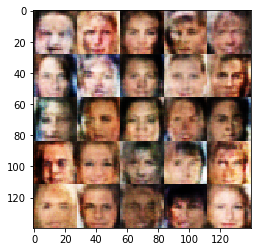

Epoch 1/1 --- Generator Loss: 2.8288 --- Discriminator Loss: -0.0185
Epoch 1/1 --- Generator Loss: 2.6536 --- Discriminator Loss: -0.0636
Epoch 1/1 --- Generator Loss: 1.7953 --- Discriminator Loss: -0.0838
Epoch 1/1 --- Generator Loss: 4.6979 --- Discriminator Loss: 0.2955
Epoch 1/1 --- Generator Loss: 2.5411 --- Discriminator Loss: -0.1302
Epoch 1/1 --- Generator Loss: 2.6146 --- Discriminator Loss: 0.0176
Epoch 1/1 --- Generator Loss: 0.2081 --- Discriminator Loss: 1.3606
Epoch 1/1 --- Generator Loss: 2.1229 --- Discriminator Loss: -0.0763
Epoch 1/1 --- Generator Loss: 2.6923 --- Discriminator Loss: -0.2348
Epoch 1/1 --- Generator Loss: 1.6109 --- Discriminator Loss: 0.0368


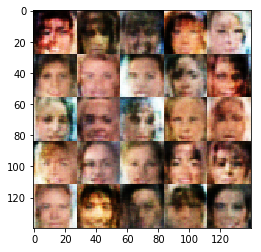

Epoch 1/1 --- Generator Loss: 0.8476 --- Discriminator Loss: 0.1362
Epoch 1/1 --- Generator Loss: 3.1860 --- Discriminator Loss: 0.1205
Epoch 1/1 --- Generator Loss: 1.8777 --- Discriminator Loss: -0.2778
Epoch 1/1 --- Generator Loss: 0.4555 --- Discriminator Loss: 0.7145
Epoch 1/1 --- Generator Loss: 0.6069 --- Discriminator Loss: 0.4738
Epoch 1/1 --- Generator Loss: 3.5456 --- Discriminator Loss: 0.0935
Epoch 1/1 --- Generator Loss: 3.2060 --- Discriminator Loss: -0.0245
Epoch 1/1 --- Generator Loss: 1.3323 --- Discriminator Loss: -0.0373
Epoch 1/1 --- Generator Loss: 0.4951 --- Discriminator Loss: 0.5386
Epoch 1/1 --- Generator Loss: 1.7541 --- Discriminator Loss: -0.1966


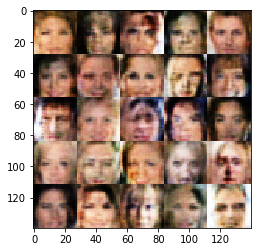

Epoch 1/1 --- Generator Loss: 3.6507 --- Discriminator Loss: 0.1034
Epoch 1/1 --- Generator Loss: 2.6683 --- Discriminator Loss: -0.1069
Epoch 1/1 --- Generator Loss: 0.9780 --- Discriminator Loss: 0.1520
Epoch 1/1 --- Generator Loss: 1.6952 --- Discriminator Loss: -0.1595
Epoch 1/1 --- Generator Loss: 3.4414 --- Discriminator Loss: 0.1365
Epoch 1/1 --- Generator Loss: 2.2332 --- Discriminator Loss: -0.1414
Epoch 1/1 --- Generator Loss: 1.9081 --- Discriminator Loss: -0.1231
Epoch 1/1 --- Generator Loss: 1.3822 --- Discriminator Loss: -0.1356
Epoch 1/1 --- Generator Loss: 2.3855 --- Discriminator Loss: -0.2113
Epoch 1/1 --- Generator Loss: 2.7993 --- Discriminator Loss: -0.1667


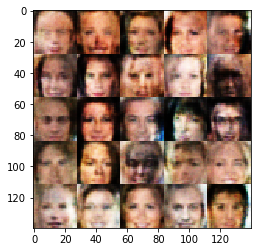

Epoch 1/1 --- Generator Loss: 2.4763 --- Discriminator Loss: 0.0153
Epoch 1/1 --- Generator Loss: 3.1369 --- Discriminator Loss: -0.1359
Epoch 1/1 --- Generator Loss: 1.2019 --- Discriminator Loss: 0.0355
Epoch 1/1 --- Generator Loss: 3.8993 --- Discriminator Loss: -0.2905
Epoch 1/1 --- Generator Loss: 2.8532 --- Discriminator Loss: -0.2580
Epoch 1/1 --- Generator Loss: 2.8844 --- Discriminator Loss: 0.0379
Epoch 1/1 --- Generator Loss: 0.3955 --- Discriminator Loss: 1.0738
Epoch 1/1 --- Generator Loss: 1.7932 --- Discriminator Loss: -0.0561
Epoch 1/1 --- Generator Loss: 3.2210 --- Discriminator Loss: 0.2669
Epoch 1/1 --- Generator Loss: 1.9237 --- Discriminator Loss: -0.0906


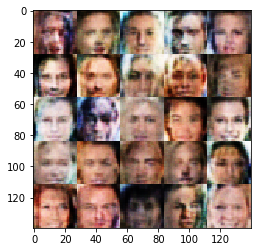

Epoch 1/1 --- Generator Loss: 0.8128 --- Discriminator Loss: 0.1868
Epoch 1/1 --- Generator Loss: 4.1812 --- Discriminator Loss: -0.0444
Epoch 1/1 --- Generator Loss: 3.5687 --- Discriminator Loss: 0.2196
Epoch 1/1 --- Generator Loss: 2.0980 --- Discriminator Loss: -0.1228
Epoch 1/1 --- Generator Loss: 2.0630 --- Discriminator Loss: -0.2968
Epoch 1/1 --- Generator Loss: 3.0717 --- Discriminator Loss: 0.2293
Epoch 1/1 --- Generator Loss: 2.8061 --- Discriminator Loss: -0.0716
Epoch 1/1 --- Generator Loss: 2.2434 --- Discriminator Loss: -0.1931
Epoch 1/1 --- Generator Loss: 1.9883 --- Discriminator Loss: -0.2687
Epoch 1/1 --- Generator Loss: 1.1160 --- Discriminator Loss: 0.0327


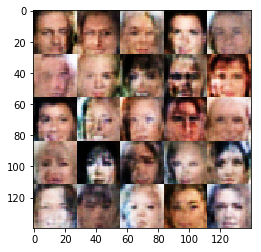

Epoch 1/1 --- Generator Loss: 3.2096 --- Discriminator Loss: -0.2380
Epoch 1/1 --- Generator Loss: 4.9036 --- Discriminator Loss: 0.8461
Epoch 1/1 --- Generator Loss: 2.7494 --- Discriminator Loss: -0.0813
Epoch 1/1 --- Generator Loss: 0.9803 --- Discriminator Loss: 0.0246
Epoch 1/1 --- Generator Loss: 3.2244 --- Discriminator Loss: -0.1997
Epoch 1/1 --- Generator Loss: 1.5875 --- Discriminator Loss: -0.1965
Epoch 1/1 --- Generator Loss: 1.2191 --- Discriminator Loss: -0.0102
Epoch 1/1 --- Generator Loss: 3.7239 --- Discriminator Loss: -0.2749
Epoch 1/1 --- Generator Loss: 1.9942 --- Discriminator Loss: -0.0069
Epoch 1/1 --- Generator Loss: 2.3201 --- Discriminator Loss: -0.1915


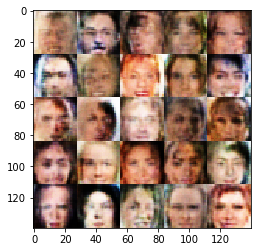

Epoch 1/1 --- Generator Loss: 0.9572 --- Discriminator Loss: 0.0460
Epoch 1/1 --- Generator Loss: 2.6951 --- Discriminator Loss: -0.3222
Epoch 1/1 --- Generator Loss: 1.6875 --- Discriminator Loss: -0.1512
Epoch 1/1 --- Generator Loss: 2.6233 --- Discriminator Loss: -0.3684
Epoch 1/1 --- Generator Loss: 2.5524 --- Discriminator Loss: 0.0622
Epoch 1/1 --- Generator Loss: 1.2635 --- Discriminator Loss: -0.0350
Epoch 1/1 --- Generator Loss: 1.7831 --- Discriminator Loss: -0.2715
Epoch 1/1 --- Generator Loss: 1.3642 --- Discriminator Loss: -0.1072
Epoch 1/1 --- Generator Loss: 1.1032 --- Discriminator Loss: 0.0629
Epoch 1/1 --- Generator Loss: 4.4168 --- Discriminator Loss: 0.5520


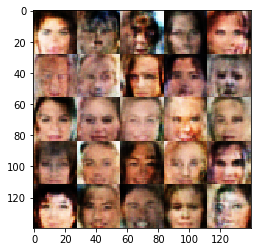

Epoch 1/1 --- Generator Loss: 2.0095 --- Discriminator Loss: -0.1192
Epoch 1/1 --- Generator Loss: 2.4875 --- Discriminator Loss: -0.4052
Epoch 1/1 --- Generator Loss: 3.4452 --- Discriminator Loss: 0.0449
Epoch 1/1 --- Generator Loss: 2.6090 --- Discriminator Loss: -0.2151
Epoch 1/1 --- Generator Loss: 1.9072 --- Discriminator Loss: -0.1432
Epoch 1/1 --- Generator Loss: 2.4401 --- Discriminator Loss: -0.2529
Epoch 1/1 --- Generator Loss: 2.7347 --- Discriminator Loss: -0.2046
Epoch 1/1 --- Generator Loss: 1.4678 --- Discriminator Loss: -0.1149
Epoch 1/1 --- Generator Loss: 0.7070 --- Discriminator Loss: 0.2672
Epoch 1/1 --- Generator Loss: 3.6583 --- Discriminator Loss: -0.0739


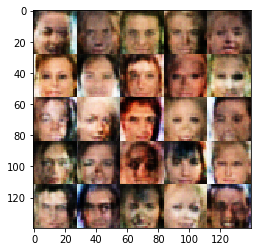

Epoch 1/1 --- Generator Loss: 2.2941 --- Discriminator Loss: -0.0407
Epoch 1/1 --- Generator Loss: 3.4884 --- Discriminator Loss: -0.3785
Epoch 1/1 --- Generator Loss: 4.3414 --- Discriminator Loss: -0.1524
Epoch 1/1 --- Generator Loss: 0.4806 --- Discriminator Loss: 0.6811
Epoch 1/1 --- Generator Loss: 2.6474 --- Discriminator Loss: -0.0089
Epoch 1/1 --- Generator Loss: 3.2350 --- Discriminator Loss: -0.4500
Epoch 1/1 --- Generator Loss: 4.1302 --- Discriminator Loss: 0.0463
Epoch 1/1 --- Generator Loss: 2.7233 --- Discriminator Loss: -0.1409
Epoch 1/1 --- Generator Loss: 2.2891 --- Discriminator Loss: 0.0644
Epoch 1/1 --- Generator Loss: 2.0868 --- Discriminator Loss: -0.3210


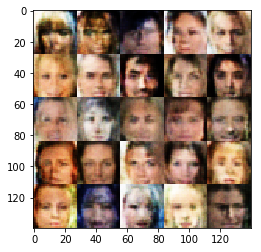

Epoch 1/1 --- Generator Loss: 3.6578 --- Discriminator Loss: -0.1573
Epoch 1/1 --- Generator Loss: 1.4325 --- Discriminator Loss: -0.1775
Epoch 1/1 --- Generator Loss: 2.0702 --- Discriminator Loss: -0.2686
Epoch 1/1 --- Generator Loss: 2.2751 --- Discriminator Loss: -0.1616
Epoch 1/1 --- Generator Loss: 0.4747 --- Discriminator Loss: 0.5717
Epoch 1/1 --- Generator Loss: 4.8862 --- Discriminator Loss: -0.0339
Epoch 1/1 --- Generator Loss: 2.0832 --- Discriminator Loss: -0.0492
Epoch 1/1 --- Generator Loss: 2.5410 --- Discriminator Loss: -0.1482
Epoch 1/1 --- Generator Loss: 3.0401 --- Discriminator Loss: -0.0628
Epoch 1/1 --- Generator Loss: 0.3817 --- Discriminator Loss: 0.9182


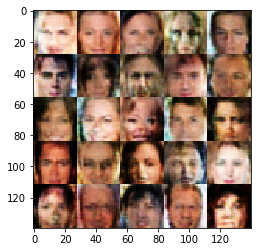

Epoch 1/1 --- Generator Loss: 0.6561 --- Discriminator Loss: 0.3696
Epoch 1/1 --- Generator Loss: 1.8281 --- Discriminator Loss: -0.2773
Epoch 1/1 --- Generator Loss: 0.1242 --- Discriminator Loss: 1.9685
Epoch 1/1 --- Generator Loss: 1.3583 --- Discriminator Loss: -0.1569
Epoch 1/1 --- Generator Loss: 1.6233 --- Discriminator Loss: -0.1414
Epoch 1/1 --- Generator Loss: 2.3616 --- Discriminator Loss: -0.1773
Epoch 1/1 --- Generator Loss: 3.0027 --- Discriminator Loss: -0.0578
Epoch 1/1 --- Generator Loss: 2.4647 --- Discriminator Loss: -0.3950
Epoch 1/1 --- Generator Loss: 2.0010 --- Discriminator Loss: -0.0944
Epoch 1/1 --- Generator Loss: 2.8937 --- Discriminator Loss: -0.2654


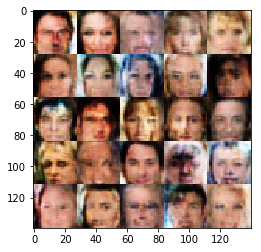

Epoch 1/1 --- Generator Loss: 2.1487 --- Discriminator Loss: -0.1635
Epoch 1/1 --- Generator Loss: 2.6011 --- Discriminator Loss: -0.3378
Epoch 1/1 --- Generator Loss: 1.6371 --- Discriminator Loss: -0.1534
Epoch 1/1 --- Generator Loss: 4.5857 --- Discriminator Loss: -0.0976
Epoch 1/1 --- Generator Loss: 2.2528 --- Discriminator Loss: -0.3365
Epoch 1/1 --- Generator Loss: 2.4756 --- Discriminator Loss: -0.3762
Epoch 1/1 --- Generator Loss: 3.5881 --- Discriminator Loss: -0.1876
Epoch 1/1 --- Generator Loss: 3.1595 --- Discriminator Loss: -0.1224
Epoch 1/1 --- Generator Loss: 2.8470 --- Discriminator Loss: -0.3335
Epoch 1/1 --- Generator Loss: 0.9501 --- Discriminator Loss: 0.0636


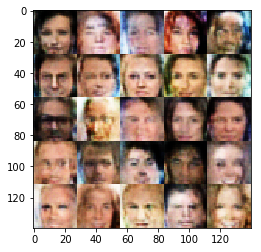

Epoch 1/1 --- Generator Loss: 1.4952 --- Discriminator Loss: -0.0646
Epoch 1/1 --- Generator Loss: 3.9907 --- Discriminator Loss: -0.0438
Epoch 1/1 --- Generator Loss: 3.3658 --- Discriminator Loss: -0.0860
Epoch 1/1 --- Generator Loss: 4.1762 --- Discriminator Loss: -0.0487
Epoch 1/1 --- Generator Loss: 5.1934 --- Discriminator Loss: 0.0839
Epoch 1/1 --- Generator Loss: 1.4823 --- Discriminator Loss: -0.0313
Epoch 1/1 --- Generator Loss: 2.4391 --- Discriminator Loss: -0.3466
Epoch 1/1 --- Generator Loss: 4.8901 --- Discriminator Loss: -0.1716
Epoch 1/1 --- Generator Loss: 3.4820 --- Discriminator Loss: -0.2940
Epoch 1/1 --- Generator Loss: 2.9866 --- Discriminator Loss: -0.5747


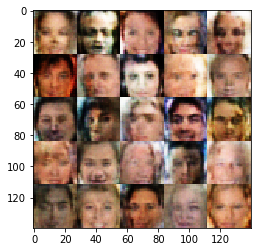

Epoch 1/1 --- Generator Loss: 3.9283 --- Discriminator Loss: 0.1260
Epoch 1/1 --- Generator Loss: 4.8069 --- Discriminator Loss: -0.3174
Epoch 1/1 --- Generator Loss: 0.4775 --- Discriminator Loss: 0.5770
Epoch 1/1 --- Generator Loss: 1.2934 --- Discriminator Loss: -0.1221
Epoch 1/1 --- Generator Loss: 0.7755 --- Discriminator Loss: 0.0789
Epoch 1/1 --- Generator Loss: 0.8181 --- Discriminator Loss: 0.0636
Epoch 1/1 --- Generator Loss: 0.3424 --- Discriminator Loss: 0.9901
Epoch 1/1 --- Generator Loss: 3.2782 --- Discriminator Loss: 0.0279
Epoch 1/1 --- Generator Loss: 3.1200 --- Discriminator Loss: -0.5746
Epoch 1/1 --- Generator Loss: 4.1269 --- Discriminator Loss: 0.1855


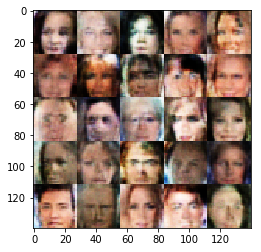

Epoch 1/1 --- Generator Loss: 0.2889 --- Discriminator Loss: 0.8931
Epoch 1/1 --- Generator Loss: 2.3902 --- Discriminator Loss: -0.4056
Epoch 1/1 --- Generator Loss: 2.0864 --- Discriminator Loss: -0.4399
Epoch 1/1 --- Generator Loss: 1.7120 --- Discriminator Loss: -0.1905
Epoch 1/1 --- Generator Loss: 4.5947 --- Discriminator Loss: -0.6228
Epoch 1/1 --- Generator Loss: 3.2186 --- Discriminator Loss: -0.4150
Epoch 1/1 --- Generator Loss: 3.6587 --- Discriminator Loss: 0.1548
Epoch 1/1 --- Generator Loss: 2.3702 --- Discriminator Loss: -0.2803
Epoch 1/1 --- Generator Loss: 5.0472 --- Discriminator Loss: -0.1182
Epoch 1/1 --- Generator Loss: 1.5914 --- Discriminator Loss: -0.1612


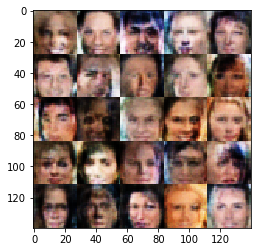

Epoch 1/1 --- Generator Loss: 3.6390 --- Discriminator Loss: -0.1335
Epoch 1/1 --- Generator Loss: 3.1293 --- Discriminator Loss: -0.3123
Epoch 1/1 --- Generator Loss: 2.1816 --- Discriminator Loss: -0.2757
Epoch 1/1 --- Generator Loss: 4.0000 --- Discriminator Loss: -0.2023
Epoch 1/1 --- Generator Loss: 1.2289 --- Discriminator Loss: -0.0377
Epoch 1/1 --- Generator Loss: 2.0164 --- Discriminator Loss: -0.1436
Epoch 1/1 --- Generator Loss: 3.1805 --- Discriminator Loss: -0.3693
Epoch 1/1 --- Generator Loss: 3.3524 --- Discriminator Loss: -0.2379
Epoch 1/1 --- Generator Loss: 1.8382 --- Discriminator Loss: -0.2614
Epoch 1/1 --- Generator Loss: 2.0804 --- Discriminator Loss: -0.3001


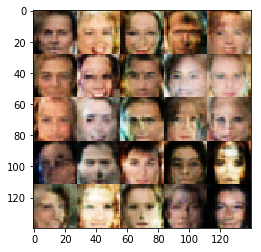

Epoch 1/1 --- Generator Loss: 2.7554 --- Discriminator Loss: -0.4531
Epoch 1/1 --- Generator Loss: 2.8537 --- Discriminator Loss: -0.6128
Epoch 1/1 --- Generator Loss: 0.8444 --- Discriminator Loss: 0.1009
Epoch 1/1 --- Generator Loss: 2.5463 --- Discriminator Loss: -0.1001
Epoch 1/1 --- Generator Loss: 4.1052 --- Discriminator Loss: 0.2176
Epoch 1/1 --- Generator Loss: 0.7065 --- Discriminator Loss: 0.2445
Epoch 1/1 --- Generator Loss: 0.3972 --- Discriminator Loss: 0.8081
Epoch 1/1 --- Generator Loss: 3.6708 --- Discriminator Loss: -0.2552
Epoch 1/1 --- Generator Loss: 2.5957 --- Discriminator Loss: -0.4564
Epoch 1/1 --- Generator Loss: 1.5921 --- Discriminator Loss: -0.3919


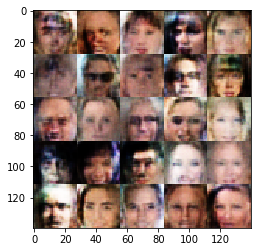

Epoch 1/1 --- Generator Loss: 2.5253 --- Discriminator Loss: -0.0816
Epoch 1/1 --- Generator Loss: 2.6724 --- Discriminator Loss: -0.4722
Epoch 1/1 --- Generator Loss: 2.8104 --- Discriminator Loss: -0.5206
Epoch 1/1 --- Generator Loss: 0.9085 --- Discriminator Loss: 0.2622
Epoch 1/1 --- Generator Loss: 2.4271 --- Discriminator Loss: -0.1602
Epoch 1/1 --- Generator Loss: 1.1593 --- Discriminator Loss: -0.0735
Epoch 1/1 --- Generator Loss: 1.4857 --- Discriminator Loss: -0.1470
Epoch 1/1 --- Generator Loss: 3.5903 --- Discriminator Loss: 0.0350
Epoch 1/1 --- Generator Loss: 2.5628 --- Discriminator Loss: -0.2064
Epoch 1/1 --- Generator Loss: 1.7440 --- Discriminator Loss: -0.0913


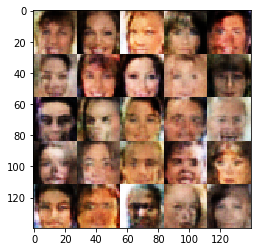

Epoch 1/1 --- Generator Loss: 3.5438 --- Discriminator Loss: -0.1732
Epoch 1/1 --- Generator Loss: 3.0941 --- Discriminator Loss: -0.5089
Epoch 1/1 --- Generator Loss: 0.9162 --- Discriminator Loss: 0.0943
Epoch 1/1 --- Generator Loss: 2.4491 --- Discriminator Loss: -0.0298
Epoch 1/1 --- Generator Loss: 2.6971 --- Discriminator Loss: -0.1647
Epoch 1/1 --- Generator Loss: 3.7366 --- Discriminator Loss: -0.5193
Epoch 1/1 --- Generator Loss: 1.3862 --- Discriminator Loss: -0.0871
Epoch 1/1 --- Generator Loss: 1.7133 --- Discriminator Loss: -0.1999
Epoch 1/1 --- Generator Loss: 1.8967 --- Discriminator Loss: -0.1967
Epoch 1/1 --- Generator Loss: 2.4068 --- Discriminator Loss: -0.2538


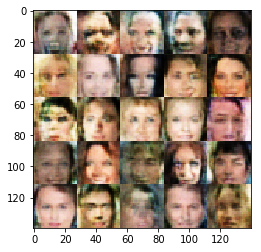

Epoch 1/1 --- Generator Loss: 4.3339 --- Discriminator Loss: -0.3478
Epoch 1/1 --- Generator Loss: 2.6138 --- Discriminator Loss: -0.2836
Epoch 1/1 --- Generator Loss: 2.5517 --- Discriminator Loss: -0.4084
Epoch 1/1 --- Generator Loss: 2.7666 --- Discriminator Loss: -0.4814
Epoch 1/1 --- Generator Loss: 2.1242 --- Discriminator Loss: -0.3643
Epoch 1/1 --- Generator Loss: 2.1055 --- Discriminator Loss: -0.2991
Epoch 1/1 --- Generator Loss: 2.6885 --- Discriminator Loss: -0.2235
Epoch 1/1 --- Generator Loss: 3.5559 --- Discriminator Loss: -0.1098
Epoch 1/1 --- Generator Loss: 3.1805 --- Discriminator Loss: -0.4381
Epoch 1/1 --- Generator Loss: 2.3036 --- Discriminator Loss: -0.3597


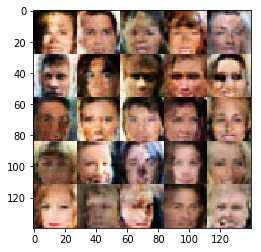

Epoch 1/1 --- Generator Loss: 3.2465 --- Discriminator Loss: -0.3841
Epoch 1/1 --- Generator Loss: 2.1223 --- Discriminator Loss: -0.1658
Epoch 1/1 --- Generator Loss: 2.0591 --- Discriminator Loss: -0.0408
Epoch 1/1 --- Generator Loss: 3.0334 --- Discriminator Loss: -0.5411
Epoch 1/1 --- Generator Loss: 2.9448 --- Discriminator Loss: -0.2673
Epoch 1/1 --- Generator Loss: 0.4095 --- Discriminator Loss: 0.5289
Epoch 1/1 --- Generator Loss: 4.2725 --- Discriminator Loss: -0.5686
Epoch 1/1 --- Generator Loss: 1.6048 --- Discriminator Loss: -0.3088
Epoch 1/1 --- Generator Loss: 2.9977 --- Discriminator Loss: -0.3065
Epoch 1/1 --- Generator Loss: 0.9941 --- Discriminator Loss: 0.0547


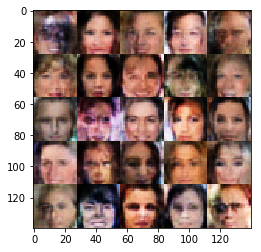

Epoch 1/1 --- Generator Loss: 0.5521 --- Discriminator Loss: 0.5407
Epoch 1/1 --- Generator Loss: 1.5871 --- Discriminator Loss: -0.1126
Epoch 1/1 --- Generator Loss: 1.3010 --- Discriminator Loss: -0.0551
Epoch 1/1 --- Generator Loss: 2.9998 --- Discriminator Loss: -0.2180
Epoch 1/1 --- Generator Loss: 1.7861 --- Discriminator Loss: -0.2160
Epoch 1/1 --- Generator Loss: 0.4299 --- Discriminator Loss: 0.6422
Epoch 1/1 --- Generator Loss: 4.1049 --- Discriminator Loss: -0.3006
Epoch 1/1 --- Generator Loss: 2.6170 --- Discriminator Loss: -0.5215
Epoch 1/1 --- Generator Loss: 4.0021 --- Discriminator Loss: -0.0066
Epoch 1/1 --- Generator Loss: 5.9239 --- Discriminator Loss: 0.2194


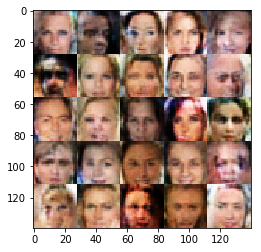

Epoch 1/1 --- Generator Loss: 1.6766 --- Discriminator Loss: -0.2965
Epoch 1/1 --- Generator Loss: 1.9395 --- Discriminator Loss: -0.1813
Epoch 1/1 --- Generator Loss: 1.3663 --- Discriminator Loss: -0.1175
Epoch 1/1 --- Generator Loss: 1.7931 --- Discriminator Loss: -0.2337
Epoch 1/1 --- Generator Loss: 4.7357 --- Discriminator Loss: -0.3460
Epoch 1/1 --- Generator Loss: 2.5725 --- Discriminator Loss: -0.4300
Epoch 1/1 --- Generator Loss: 1.5552 --- Discriminator Loss: -0.1439
Epoch 1/1 --- Generator Loss: 6.8804 --- Discriminator Loss: 0.8703
Epoch 1/1 --- Generator Loss: 4.1417 --- Discriminator Loss: -0.3832
Epoch 1/1 --- Generator Loss: 2.9380 --- Discriminator Loss: -0.6237


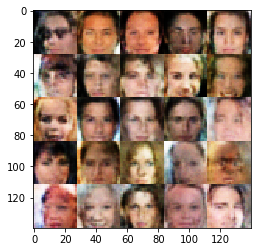

Epoch 1/1 --- Generator Loss: 1.7909 --- Discriminator Loss: -0.3761
Epoch 1/1 --- Generator Loss: 4.4378 --- Discriminator Loss: -0.2825
Epoch 1/1 --- Generator Loss: 5.1469 --- Discriminator Loss: 0.5919
Epoch 1/1 --- Generator Loss: 5.5787 --- Discriminator Loss: 0.2087
Epoch 1/1 --- Generator Loss: 2.9245 --- Discriminator Loss: -0.2783
Epoch 1/1 --- Generator Loss: 1.0204 --- Discriminator Loss: -0.0318
Epoch 1/1 --- Generator Loss: 2.6842 --- Discriminator Loss: -0.2793
Epoch 1/1 --- Generator Loss: 1.2033 --- Discriminator Loss: 0.0020
Epoch 1/1 --- Generator Loss: 2.9059 --- Discriminator Loss: -0.4170
Epoch 1/1 --- Generator Loss: 1.3041 --- Discriminator Loss: -0.0924


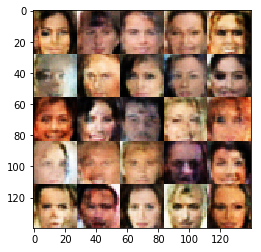

Epoch 1/1 --- Generator Loss: 2.7267 --- Discriminator Loss: -0.5007
Epoch 1/1 --- Generator Loss: 2.8285 --- Discriminator Loss: -0.4973
Epoch 1/1 --- Generator Loss: 2.3343 --- Discriminator Loss: -0.2127
Epoch 1/1 --- Generator Loss: 3.6598 --- Discriminator Loss: -0.0497
Epoch 1/1 --- Generator Loss: 3.6303 --- Discriminator Loss: -0.3445
Epoch 1/1 --- Generator Loss: 2.9150 --- Discriminator Loss: -0.4855
Epoch 1/1 --- Generator Loss: 2.4965 --- Discriminator Loss: -0.3182
Epoch 1/1 --- Generator Loss: 3.3166 --- Discriminator Loss: -0.3728
Epoch 1/1 --- Generator Loss: 3.1938 --- Discriminator Loss: -0.2538
Epoch 1/1 --- Generator Loss: 2.0871 --- Discriminator Loss: -0.3937


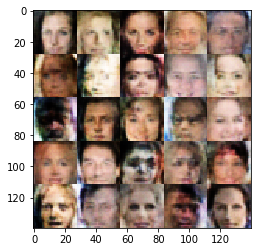

Epoch 1/1 --- Generator Loss: 5.2348 --- Discriminator Loss: -0.4447
Epoch 1/1 --- Generator Loss: 0.4182 --- Discriminator Loss: 0.7043
Epoch 1/1 --- Generator Loss: 3.4531 --- Discriminator Loss: -0.8592
Epoch 1/1 --- Generator Loss: 4.5310 --- Discriminator Loss: 0.0268
Epoch 1/1 --- Generator Loss: 3.0257 --- Discriminator Loss: -0.4530
Epoch 1/1 --- Generator Loss: 1.6149 --- Discriminator Loss: -0.2649
Epoch 1/1 --- Generator Loss: 1.5378 --- Discriminator Loss: -0.3521
Epoch 1/1 --- Generator Loss: 2.8313 --- Discriminator Loss: -0.2827
Epoch 1/1 --- Generator Loss: 1.2683 --- Discriminator Loss: -0.1183
Epoch 1/1 --- Generator Loss: 2.6046 --- Discriminator Loss: -0.2180


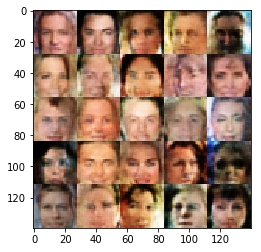

Epoch 1/1 --- Generator Loss: 2.4039 --- Discriminator Loss: -0.1532
Epoch 1/1 --- Generator Loss: 2.9746 --- Discriminator Loss: -0.5043
Epoch 1/1 --- Generator Loss: 0.1272 --- Discriminator Loss: 1.5917
Epoch 1/1 --- Generator Loss: 5.3951 --- Discriminator Loss: -0.4147
Epoch 1/1 --- Generator Loss: 3.5948 --- Discriminator Loss: -0.5578
Epoch 1/1 --- Generator Loss: 5.7528 --- Discriminator Loss: 0.5197
Epoch 1/1 --- Generator Loss: 0.9702 --- Discriminator Loss: -0.0526
Epoch 1/1 --- Generator Loss: 0.7190 --- Discriminator Loss: 0.2404
Epoch 1/1 --- Generator Loss: 3.0572 --- Discriminator Loss: -0.4834
Epoch 1/1 --- Generator Loss: 2.0059 --- Discriminator Loss: -0.3503


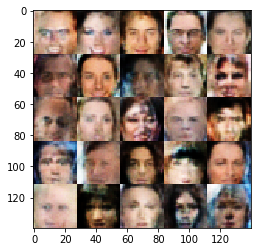

Epoch 1/1 --- Generator Loss: 3.2269 --- Discriminator Loss: 0.2081
Epoch 1/1 --- Generator Loss: 4.0595 --- Discriminator Loss: -0.2815
Epoch 1/1 --- Generator Loss: 0.4275 --- Discriminator Loss: 0.8585
Epoch 1/1 --- Generator Loss: 3.1604 --- Discriminator Loss: -0.0255
Epoch 1/1 --- Generator Loss: 0.7686 --- Discriminator Loss: 0.1813
Epoch 1/1 --- Generator Loss: 2.0118 --- Discriminator Loss: -0.2361
Epoch 1/1 --- Generator Loss: 2.0762 --- Discriminator Loss: -0.1413
Epoch 1/1 --- Generator Loss: 3.3965 --- Discriminator Loss: -0.5807
Epoch 1/1 --- Generator Loss: 3.4343 --- Discriminator Loss: 0.0094
Epoch 1/1 --- Generator Loss: 2.5873 --- Discriminator Loss: -0.3663


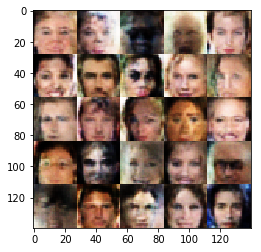

Epoch 1/1 --- Generator Loss: 1.7951 --- Discriminator Loss: -0.3423
Epoch 1/1 --- Generator Loss: 5.1889 --- Discriminator Loss: -0.1629
Epoch 1/1 --- Generator Loss: 5.6629 --- Discriminator Loss: -0.0212
Epoch 1/1 --- Generator Loss: 3.1030 --- Discriminator Loss: -0.5214
Epoch 1/1 --- Generator Loss: 1.2428 --- Discriminator Loss: -0.0762
Epoch 1/1 --- Generator Loss: 2.1374 --- Discriminator Loss: -0.2989
Epoch 1/1 --- Generator Loss: 0.4127 --- Discriminator Loss: 0.7441
Epoch 1/1 --- Generator Loss: 2.2741 --- Discriminator Loss: -0.2479
Epoch 1/1 --- Generator Loss: 3.0131 --- Discriminator Loss: -0.5590
Epoch 1/1 --- Generator Loss: 3.9518 --- Discriminator Loss: -0.3855


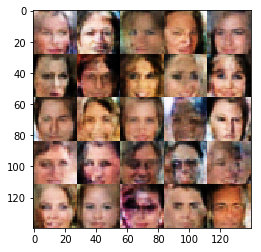

Epoch 1/1 --- Generator Loss: 2.2374 --- Discriminator Loss: -0.3774
Epoch 1/1 --- Generator Loss: 1.9115 --- Discriminator Loss: -0.3547
Epoch 1/1 --- Generator Loss: 2.4126 --- Discriminator Loss: -0.1643
Epoch 1/1 --- Generator Loss: 2.6650 --- Discriminator Loss: -0.3559
Epoch 1/1 --- Generator Loss: 2.1916 --- Discriminator Loss: -0.1847
Epoch 1/1 --- Generator Loss: 6.4664 --- Discriminator Loss: 0.1474
Epoch 1/1 --- Generator Loss: 1.4932 --- Discriminator Loss: -0.3044
Epoch 1/1 --- Generator Loss: 3.5977 --- Discriminator Loss: 0.0329
Epoch 1/1 --- Generator Loss: 2.9725 --- Discriminator Loss: -0.5162
Epoch 1/1 --- Generator Loss: 2.9371 --- Discriminator Loss: -0.3461


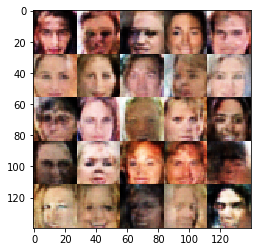

Epoch 1/1 --- Generator Loss: 1.8793 --- Discriminator Loss: -0.3167
Epoch 1/1 --- Generator Loss: 1.5742 --- Discriminator Loss: -0.1536
Epoch 1/1 --- Generator Loss: 5.3684 --- Discriminator Loss: -0.1806
Epoch 1/1 --- Generator Loss: 1.9015 --- Discriminator Loss: -0.2974
Epoch 1/1 --- Generator Loss: 1.8003 --- Discriminator Loss: -0.1327
Epoch 1/1 --- Generator Loss: 2.2772 --- Discriminator Loss: -0.1510
Epoch 1/1 --- Generator Loss: 2.2953 --- Discriminator Loss: -0.3947
Epoch 1/1 --- Generator Loss: 3.6752 --- Discriminator Loss: -0.6552
Epoch 1/1 --- Generator Loss: 4.1049 --- Discriminator Loss: -0.2807
Epoch 1/1 --- Generator Loss: 3.2051 --- Discriminator Loss: -0.5560


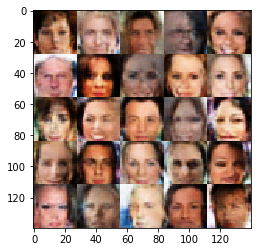

Epoch 1/1 --- Generator Loss: 4.8429 --- Discriminator Loss: -0.0625
Epoch 1/1 --- Generator Loss: 0.6980 --- Discriminator Loss: 0.3331
Epoch 1/1 --- Generator Loss: 3.1180 --- Discriminator Loss: -0.4563
Epoch 1/1 --- Generator Loss: 1.1832 --- Discriminator Loss: -0.1130
Epoch 1/1 --- Generator Loss: 1.8091 --- Discriminator Loss: -0.3025
Epoch 1/1 --- Generator Loss: 3.3417 --- Discriminator Loss: -0.2066
Epoch 1/1 --- Generator Loss: 2.7509 --- Discriminator Loss: -0.4522
Epoch 1/1 --- Generator Loss: 4.7569 --- Discriminator Loss: 0.1549
Epoch 1/1 --- Generator Loss: 5.3658 --- Discriminator Loss: -0.2398
Epoch 1/1 --- Generator Loss: 5.3239 --- Discriminator Loss: -0.0014


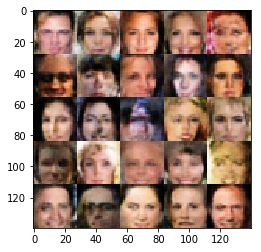

Epoch 1/1 --- Generator Loss: 4.0772 --- Discriminator Loss: 0.3058
Epoch 1/1 --- Generator Loss: 2.6846 --- Discriminator Loss: -0.5285
Epoch 1/1 --- Generator Loss: 3.7044 --- Discriminator Loss: -0.2862
Epoch 1/1 --- Generator Loss: 5.3260 --- Discriminator Loss: -0.0443
Epoch 1/1 --- Generator Loss: 2.0864 --- Discriminator Loss: -0.2884
Epoch 1/1 --- Generator Loss: 2.9768 --- Discriminator Loss: -0.6770
Epoch 1/1 --- Generator Loss: 0.5517 --- Discriminator Loss: 0.4592
Epoch 1/1 --- Generator Loss: 3.5910 --- Discriminator Loss: -0.1258
Epoch 1/1 --- Generator Loss: 1.5092 --- Discriminator Loss: -0.0320
Epoch 1/1 --- Generator Loss: 3.0047 --- Discriminator Loss: -0.2287


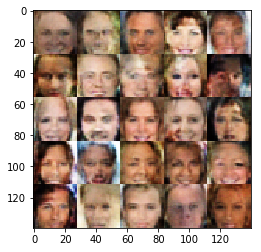

Epoch 1/1 --- Generator Loss: 1.2622 --- Discriminator Loss: -0.3576
Epoch 1/1 --- Generator Loss: 3.6507 --- Discriminator Loss: -0.3222
Epoch 1/1 --- Generator Loss: 2.0952 --- Discriminator Loss: -0.3122
Epoch 1/1 --- Generator Loss: 1.5555 --- Discriminator Loss: -0.1910
Epoch 1/1 --- Generator Loss: 2.6171 --- Discriminator Loss: -0.4323
Epoch 1/1 --- Generator Loss: 1.0797 --- Discriminator Loss: -0.0479
Epoch 1/1 --- Generator Loss: 1.6394 --- Discriminator Loss: -0.3094
Epoch 1/1 --- Generator Loss: 0.7098 --- Discriminator Loss: 0.1743
Epoch 1/1 --- Generator Loss: 0.2828 --- Discriminator Loss: 1.0429
Epoch 1/1 --- Generator Loss: 4.1977 --- Discriminator Loss: -0.4538


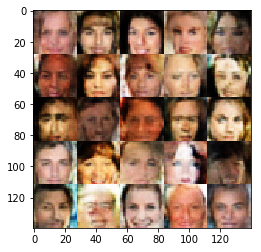

Epoch 1/1 --- Generator Loss: 3.1047 --- Discriminator Loss: -0.5372
Epoch 1/1 --- Generator Loss: 2.2374 --- Discriminator Loss: -0.3180
Epoch 1/1 --- Generator Loss: 1.0071 --- Discriminator Loss: 0.0228
Epoch 1/1 --- Generator Loss: 2.9318 --- Discriminator Loss: -0.3293
Epoch 1/1 --- Generator Loss: 2.6927 --- Discriminator Loss: -0.6317
Epoch 1/1 --- Generator Loss: 3.0266 --- Discriminator Loss: -0.2658
Epoch 1/1 --- Generator Loss: 3.3638 --- Discriminator Loss: -0.2626
Epoch 1/1 --- Generator Loss: 3.9394 --- Discriminator Loss: -0.5362
Epoch 1/1 --- Generator Loss: 4.5031 --- Discriminator Loss: -0.0884
Epoch 1/1 --- Generator Loss: 0.9156 --- Discriminator Loss: 0.0328


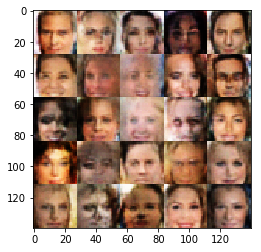

Epoch 1/1 --- Generator Loss: 2.6808 --- Discriminator Loss: -0.3696
Epoch 1/1 --- Generator Loss: 2.3519 --- Discriminator Loss: -0.4537
Epoch 1/1 --- Generator Loss: 2.4518 --- Discriminator Loss: -0.2404
Epoch 1/1 --- Generator Loss: 3.0870 --- Discriminator Loss: -0.6187
Epoch 1/1 --- Generator Loss: 5.5412 --- Discriminator Loss: 0.1805
Epoch 1/1 --- Generator Loss: 5.2575 --- Discriminator Loss: 0.6341
Epoch 1/1 --- Generator Loss: 3.7257 --- Discriminator Loss: -0.1595
Epoch 1/1 --- Generator Loss: 2.3397 --- Discriminator Loss: -0.3849
Epoch 1/1 --- Generator Loss: 4.7197 --- Discriminator Loss: -0.2449
Epoch 1/1 --- Generator Loss: 2.8156 --- Discriminator Loss: -0.6016


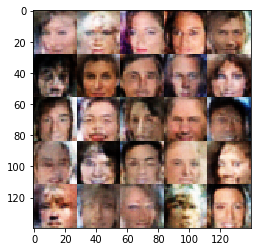

Epoch 1/1 --- Generator Loss: 3.2261 --- Discriminator Loss: -0.5556
Epoch 1/1 --- Generator Loss: 2.3969 --- Discriminator Loss: -0.1755
Epoch 1/1 --- Generator Loss: 3.4467 --- Discriminator Loss: -0.2168
Epoch 1/1 --- Generator Loss: 0.7582 --- Discriminator Loss: 0.1024
Epoch 1/1 --- Generator Loss: 2.0910 --- Discriminator Loss: -0.4048
Epoch 1/1 --- Generator Loss: 0.8457 --- Discriminator Loss: 0.0398
Epoch 1/1 --- Generator Loss: 3.8553 --- Discriminator Loss: -0.3194
Epoch 1/1 --- Generator Loss: 4.1540 --- Discriminator Loss: -0.1156
Epoch 1/1 --- Generator Loss: 3.1096 --- Discriminator Loss: -0.2842
Epoch 1/1 --- Generator Loss: 2.1711 --- Discriminator Loss: -0.3043


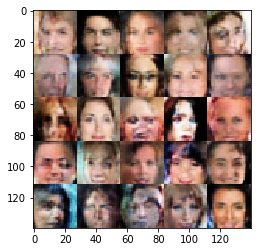

Epoch 1/1 --- Generator Loss: 2.8538 --- Discriminator Loss: -0.3292
Epoch 1/1 --- Generator Loss: 2.6565 --- Discriminator Loss: -0.3806
Epoch 1/1 --- Generator Loss: 3.0513 --- Discriminator Loss: -0.0246
Epoch 1/1 --- Generator Loss: 2.4968 --- Discriminator Loss: -0.0737
Epoch 1/1 --- Generator Loss: 1.4017 --- Discriminator Loss: -0.2132
Epoch 1/1 --- Generator Loss: 1.8793 --- Discriminator Loss: -0.1924
Epoch 1/1 --- Generator Loss: 2.6997 --- Discriminator Loss: -0.5653
Epoch 1/1 --- Generator Loss: 1.7026 --- Discriminator Loss: -0.3103
Epoch 1/1 --- Generator Loss: 2.4253 --- Discriminator Loss: -0.3724
Epoch 1/1 --- Generator Loss: 2.7267 --- Discriminator Loss: -0.5838


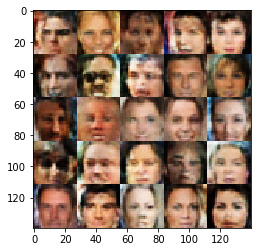

Epoch 1/1 --- Generator Loss: 3.5519 --- Discriminator Loss: -0.2532
Epoch 1/1 --- Generator Loss: 2.6552 --- Discriminator Loss: -0.1738
Epoch 1/1 --- Generator Loss: 5.7595 --- Discriminator Loss: 0.1817
Epoch 1/1 --- Generator Loss: 4.8566 --- Discriminator Loss: 0.6263
Epoch 1/1 --- Generator Loss: 4.6487 --- Discriminator Loss: -0.2143
Epoch 1/1 --- Generator Loss: 0.6948 --- Discriminator Loss: 0.1521
Epoch 1/1 --- Generator Loss: 1.7940 --- Discriminator Loss: -0.2009
Epoch 1/1 --- Generator Loss: 0.9921 --- Discriminator Loss: 0.0105
Epoch 1/1 --- Generator Loss: 4.3079 --- Discriminator Loss: -0.0282
Epoch 1/1 --- Generator Loss: 2.4707 --- Discriminator Loss: -0.2013


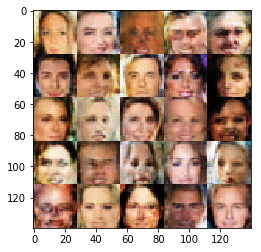

Epoch 1/1 --- Generator Loss: 3.6204 --- Discriminator Loss: -0.2386
Epoch 1/1 --- Generator Loss: 4.2491 --- Discriminator Loss: 0.0340
Epoch 1/1 --- Generator Loss: 1.2583 --- Discriminator Loss: -0.2015
Epoch 1/1 --- Generator Loss: 0.3493 --- Discriminator Loss: 0.6624
Epoch 1/1 --- Generator Loss: 2.8791 --- Discriminator Loss: -0.6554
Epoch 1/1 --- Generator Loss: 2.5984 --- Discriminator Loss: -0.2253
Epoch 1/1 --- Generator Loss: 2.6674 --- Discriminator Loss: -0.5178
Epoch 1/1 --- Generator Loss: 2.1857 --- Discriminator Loss: -0.3840
Epoch 1/1 --- Generator Loss: 3.7209 --- Discriminator Loss: -0.4889
Epoch 1/1 --- Generator Loss: 3.9498 --- Discriminator Loss: 0.1609


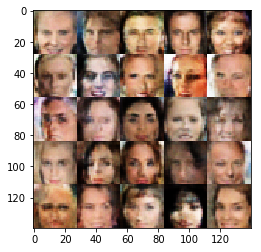

Epoch 1/1 --- Generator Loss: 5.1964 --- Discriminator Loss: -0.2667
Epoch 1/1 --- Generator Loss: 2.5186 --- Discriminator Loss: -0.2565
Epoch 1/1 --- Generator Loss: 2.4455 --- Discriminator Loss: -0.1673
Epoch 1/1 --- Generator Loss: 4.2174 --- Discriminator Loss: -0.2195
Epoch 1/1 --- Generator Loss: 0.9678 --- Discriminator Loss: 0.1415
Epoch 1/1 --- Generator Loss: 2.4241 --- Discriminator Loss: -0.4183
Epoch 1/1 --- Generator Loss: 2.5675 --- Discriminator Loss: -0.3130
Epoch 1/1 --- Generator Loss: 3.3135 --- Discriminator Loss: -0.3241
Epoch 1/1 --- Generator Loss: 1.6168 --- Discriminator Loss: -0.2418
Epoch 1/1 --- Generator Loss: 1.7688 --- Discriminator Loss: -0.2327


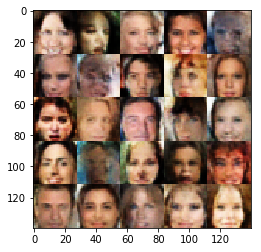

Epoch 1/1 --- Generator Loss: 0.8377 --- Discriminator Loss: 0.0907
Epoch 1/1 --- Generator Loss: 2.7520 --- Discriminator Loss: -0.3442
Epoch 1/1 --- Generator Loss: 2.3898 --- Discriminator Loss: -0.2844
Epoch 1/1 --- Generator Loss: 3.8312 --- Discriminator Loss: -0.5358
Epoch 1/1 --- Generator Loss: 3.7284 --- Discriminator Loss: -0.0332
Epoch 1/1 --- Generator Loss: 2.9883 --- Discriminator Loss: -0.3918
Epoch 1/1 --- Generator Loss: 5.0742 --- Discriminator Loss: 0.6414
Epoch 1/1 --- Generator Loss: 5.1285 --- Discriminator Loss: -0.0431
Epoch 1/1 --- Generator Loss: 3.0537 --- Discriminator Loss: -0.5728
Epoch 1/1 --- Generator Loss: 4.4871 --- Discriminator Loss: -0.2231


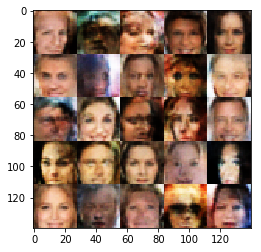

Epoch 1/1 --- Generator Loss: 1.7868 --- Discriminator Loss: -0.2365
Epoch 1/1 --- Generator Loss: 3.9417 --- Discriminator Loss: 0.2146
Epoch 1/1 --- Generator Loss: 0.9653 --- Discriminator Loss: -0.0114
Epoch 1/1 --- Generator Loss: 3.3840 --- Discriminator Loss: -0.3128
Epoch 1/1 --- Generator Loss: 2.9531 --- Discriminator Loss: -0.5731
Epoch 1/1 --- Generator Loss: 3.9332 --- Discriminator Loss: -0.0210
Epoch 1/1 --- Generator Loss: 3.6422 --- Discriminator Loss: -0.4837
Epoch 1/1 --- Generator Loss: 0.4671 --- Discriminator Loss: 0.5929
Epoch 1/1 --- Generator Loss: 3.1874 --- Discriminator Loss: -0.3902
Epoch 1/1 --- Generator Loss: 1.9107 --- Discriminator Loss: -0.2803


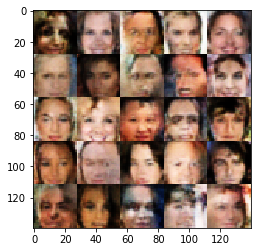

Epoch 1/1 --- Generator Loss: 5.7745 --- Discriminator Loss: -0.1247
Epoch 1/1 --- Generator Loss: 2.1119 --- Discriminator Loss: -0.3305
Epoch 1/1 --- Generator Loss: 4.5397 --- Discriminator Loss: -0.3721
Epoch 1/1 --- Generator Loss: 3.6055 --- Discriminator Loss: -0.2117
Epoch 1/1 --- Generator Loss: 2.7203 --- Discriminator Loss: -0.5531
Epoch 1/1 --- Generator Loss: 2.8972 --- Discriminator Loss: -0.6942
Epoch 1/1 --- Generator Loss: 6.3171 --- Discriminator Loss: 1.0956
Epoch 1/1 --- Generator Loss: 3.1823 --- Discriminator Loss: -0.5018
Epoch 1/1 --- Generator Loss: 2.6524 --- Discriminator Loss: -0.2587
Epoch 1/1 --- Generator Loss: 1.1967 --- Discriminator Loss: -0.1709


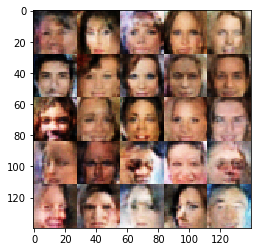

Epoch 1/1 --- Generator Loss: 1.5208 --- Discriminator Loss: -0.3999
Epoch 1/1 --- Generator Loss: 0.5234 --- Discriminator Loss: 0.3633
Epoch 1/1 --- Generator Loss: 3.1810 --- Discriminator Loss: -0.5433
Epoch 1/1 --- Generator Loss: 2.5568 --- Discriminator Loss: -0.4978
Epoch 1/1 --- Generator Loss: 7.1130 --- Discriminator Loss: -0.2341
Epoch 1/1 --- Generator Loss: 4.9890 --- Discriminator Loss: 0.2437
Epoch 1/1 --- Generator Loss: 4.3842 --- Discriminator Loss: -0.3726
Epoch 1/1 --- Generator Loss: 4.3203 --- Discriminator Loss: 0.1898
Epoch 1/1 --- Generator Loss: 1.9952 --- Discriminator Loss: -0.1522
Epoch 1/1 --- Generator Loss: 2.7461 --- Discriminator Loss: -0.4640


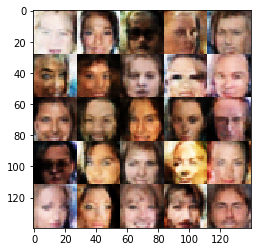

Epoch 1/1 --- Generator Loss: 5.1558 --- Discriminator Loss: 0.3127
Epoch 1/1 --- Generator Loss: 2.8264 --- Discriminator Loss: -0.3324
Epoch 1/1 --- Generator Loss: 1.5687 --- Discriminator Loss: -0.2696
Epoch 1/1 --- Generator Loss: 3.4783 --- Discriminator Loss: -0.4719
Epoch 1/1 --- Generator Loss: 2.9248 --- Discriminator Loss: -0.5344
Epoch 1/1 --- Generator Loss: 4.4579 --- Discriminator Loss: -0.4424
Epoch 1/1 --- Generator Loss: 3.9309 --- Discriminator Loss: -0.2859
Epoch 1/1 --- Generator Loss: 2.3357 --- Discriminator Loss: -0.3607
Epoch 1/1 --- Generator Loss: 1.9154 --- Discriminator Loss: -0.3853
Epoch 1/1 --- Generator Loss: 6.7845 --- Discriminator Loss: 1.1720


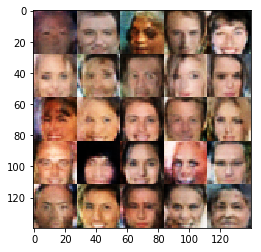

Epoch 1/1 --- Generator Loss: 3.5040 --- Discriminator Loss: -0.2725
Epoch 1/1 --- Generator Loss: 2.6337 --- Discriminator Loss: -0.2235
Epoch 1/1 --- Generator Loss: 3.1722 --- Discriminator Loss: -0.5512
Epoch 1/1 --- Generator Loss: 2.6853 --- Discriminator Loss: -0.2064
Epoch 1/1 --- Generator Loss: 3.2319 --- Discriminator Loss: -0.5740
Epoch 1/1 --- Generator Loss: 3.4748 --- Discriminator Loss: -0.4552
Epoch 1/1 --- Generator Loss: 4.9027 --- Discriminator Loss: 0.0333
Epoch 1/1 --- Generator Loss: 2.7639 --- Discriminator Loss: -0.6680
Epoch 1/1 --- Generator Loss: 4.1201 --- Discriminator Loss: -0.4904
Epoch 1/1 --- Generator Loss: 3.8510 --- Discriminator Loss: -0.5887


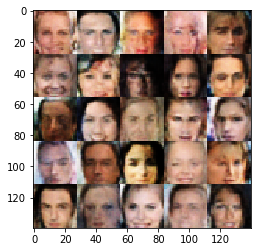

Epoch 1/1 --- Generator Loss: 4.6375 --- Discriminator Loss: -0.5132
Epoch 1/1 --- Generator Loss: 3.0207 --- Discriminator Loss: -0.3984
Epoch 1/1 --- Generator Loss: 2.1125 --- Discriminator Loss: -0.3310
Epoch 1/1 --- Generator Loss: 4.3103 --- Discriminator Loss: -0.4189
Epoch 1/1 --- Generator Loss: 2.6942 --- Discriminator Loss: -0.3509
Epoch 1/1 --- Generator Loss: 4.2086 --- Discriminator Loss: -0.5123
Epoch 1/1 --- Generator Loss: 5.2083 --- Discriminator Loss: -0.4201
Epoch 1/1 --- Generator Loss: 4.9191 --- Discriminator Loss: 0.0260
Epoch 1/1 --- Generator Loss: 1.4873 --- Discriminator Loss: -0.3103
Epoch 1/1 --- Generator Loss: 1.9777 --- Discriminator Loss: -0.1992


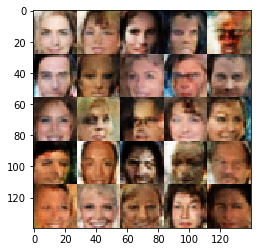

Epoch 1/1 --- Generator Loss: 3.7069 --- Discriminator Loss: -0.2877
Epoch 1/1 --- Generator Loss: 2.7249 --- Discriminator Loss: -0.3089
Epoch 1/1 --- Generator Loss: 4.6539 --- Discriminator Loss: 0.0788
Epoch 1/1 --- Generator Loss: 2.0524 --- Discriminator Loss: -0.5085
Epoch 1/1 --- Generator Loss: 4.7112 --- Discriminator Loss: 0.0498
Epoch 1/1 --- Generator Loss: 3.3867 --- Discriminator Loss: -0.3429
Epoch 1/1 --- Generator Loss: 2.3112 --- Discriminator Loss: -0.4393
Epoch 1/1 --- Generator Loss: 2.4562 --- Discriminator Loss: -0.3806
Epoch 1/1 --- Generator Loss: 4.6460 --- Discriminator Loss: -0.1610
Epoch 1/1 --- Generator Loss: 1.3174 --- Discriminator Loss: -0.2302


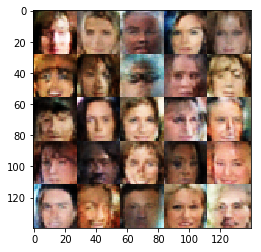

Epoch 1/1 --- Generator Loss: 2.5292 --- Discriminator Loss: -0.3586
Epoch 1/1 --- Generator Loss: 3.2611 --- Discriminator Loss: -0.4416
Epoch 1/1 --- Generator Loss: 5.0235 --- Discriminator Loss: -0.2907
Epoch 1/1 --- Generator Loss: 2.9700 --- Discriminator Loss: -0.3450
Epoch 1/1 --- Generator Loss: 1.7935 --- Discriminator Loss: -0.3428
Epoch 1/1 --- Generator Loss: 4.2350 --- Discriminator Loss: -0.3845
Epoch 1/1 --- Generator Loss: 4.2317 --- Discriminator Loss: -0.0772
Epoch 1/1 --- Generator Loss: 3.4961 --- Discriminator Loss: -0.5313
Epoch 1/1 --- Generator Loss: 3.4630 --- Discriminator Loss: -0.3798
Epoch 1/1 --- Generator Loss: 2.1672 --- Discriminator Loss: -0.4926


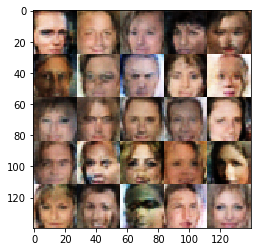

Epoch 1/1 --- Generator Loss: 1.3175 --- Discriminator Loss: -0.2976
Epoch 1/1 --- Generator Loss: 3.0438 --- Discriminator Loss: -0.5637
Epoch 1/1 --- Generator Loss: 3.3892 --- Discriminator Loss: -0.2301


In [75]:
batch_size = 32
z_dim = 100
learning_rate = 1e-4
beta1 = 0.1


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.